### **Initial Configuration**

In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import talib
import torch
import os
from datetime import datetime

from environment import Env
from networks import AdvantageActorCritic
from agent import Agent

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.cuda.is_available() or torch.backends.mps.is_available()}")

✓ All imports successful!
PyTorch version: 2.8.0
Device available: True


In [5]:
# Data configuration
START_DATE = '2010-01-01'
END_DATE = '2024-12-31'
TICKERS = ['VNQ', 'SPY', 'GLD', 'BTC-USD']

# Model configuration
LAG = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

# Evaluation configuration
BENCHMARK_WEIGHTS = np.array([0.1, 0.8, 0.05, 0.05, 0])  # VNQ, SPY, GLD, BTC, Cash

print(f"📊 Configuration loaded")
print(f"   Tickers: {TICKERS}")
print(f"   Date range: {START_DATE} to {END_DATE}")
print(f"   Device: {DEVICE}")

📊 Configuration loaded
   Tickers: ['VNQ', 'SPY', 'GLD', 'BTC-USD']
   Date range: 2010-01-01 to 2024-12-31
   Device: mps


### **Data & Features**

In [6]:
print("Downloading price data...")
df = yf.download(TICKERS, start=START_DATE, end=END_DATE)
df = df['Close']
df = df.dropna().copy()

print(f"✓ Downloaded {len(df)} days of data")
print(f"  Date range: {df.index[0]} to {df.index[-1]}")

# Load VIX data
print("\nLoading VIX features...")
vix_df = pd.read_csv('../../data/VIX_CLS_2010_2024.csv')
vix_df['observation_date'] = pd.to_datetime(vix_df['observation_date'])
vix_df = vix_df.set_index('observation_date')
vix_df = vix_df.rename(columns={'VIXCLS': 'VIX'})

vix3m_df = pd.read_csv('../../data/VIX3M_CLS_2010_2024.csv')
vix3m_df['observation_date'] = pd.to_datetime(vix3m_df['observation_date'])
vix3m_df = vix3m_df.set_index('observation_date')
vix3m_df = vix3m_df.rename(columns={'VXVCLS': 'VIX3M'})

vix_combined = vix_df.join(vix3m_df, how='outer')
df = df.join(vix_combined, how='left')
df['VIX'] = df['VIX'].ffill()
df['VIX3M'] = df['VIX3M'].ffill()

# VIX features
df['VIX_normalized'] = (df['VIX'] - 20) / 20

def get_vix_regime(vix):
    if vix < 15:
        return -1.0
    elif vix < 25:
        return 0.0
    else:
        return 1.0

df['VIX_regime'] = df['VIX'].apply(get_vix_regime)
df['VIX_term_structure'] = (df['VIX3M'] - df['VIX']) / df['VIX']
df['VIX_term_structure'] = np.clip(df['VIX_term_structure'], -1, 1)

print("✓ VIX features added")

# RSI features
print("Calculating RSI...")
for ticker in TICKERS:
    df[ticker + '_RSI'] = talib.RSI(df[ticker], timeperiod=14) / 50 - 1

# MACD features
print("Calculating MACD...")
for ticker in TICKERS:
    macd, signal, hist = talib.MACD(df[ticker], fastperiod=12, slowperiod=26, signalperiod=9)
    df[ticker + '_MACD'] = macd / df[ticker] * 10
    df[ticker + '_MACD_Signal'] = signal / df[ticker] * 10

# Volatility features
print("Calculating volatility...")
for ticker in TICKERS:
    returns = df[ticker].pct_change()
    df[ticker + '_volatility'] = returns.rolling(20).std() * np.sqrt(252)
    df[ticker + '_volatility'] = (df[ticker + '_volatility'] - 0.25) / 0.25

df = df.dropna()

print(f"\n✓ Feature engineering complete")
print(f"  Total features: {len([col for col in df.columns if col not in TICKERS + ['VIX', 'VIX3M']])}")
print(f"  Data shape: {df.shape}")

/var/folders/3v/2yw6c8qx0n55dsz1fdnrlrm80000gn/T/ipykernel_9103/694313803.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  4 of 4 completed

✓ Downloaded 2589 days of data
  Date range: 2014-09-17 00:00:00 to 2024-12-30 00:00:00

Loading VIX features...
✓ VIX features added
Calculating RSI...
Calculating MACD...
Calculating volatility...

✓ Feature engineering complete
  Total features: 19
  Data shape: (2556, 25)


In [7]:
# Split data (80/20)
n_train = int(0.8 * len(df))
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

print("📊 Data Split:")
print(f"   Train: {len(df_train)} days ({df_train.index[0]} to {df_train.index[-1]})")
print(f"   Test:  {len(df_test)} days ({df_test.index[0]} to {df_test.index[-1]})")

# Create test environment
env_test = Env(df_test, TICKERS, lag=LAG)
print(f"\n✓ Test environment created")
print(f"   State dimension: {env_test.states.shape[1] * env_test.lag}")

📊 Data Split:
   Train: 2044 days (2014-11-03 00:00:00 to 2022-12-14 00:00:00)
   Test:  512 days (2022-12-15 00:00:00 to 2024-12-30 00:00:00)
Environment initialized:
  - State features: 19
  - Features per ticker: 4 (RSI, MACD, MACD_Signal, volatility)
  - Market features: 3 (VIX_normalized, VIX_regime, VIX_term_structure)
  - Total state dimension per timestep: 19
  - Lag (temporal window): 5
  - Final input dimension: 95
  - Number of data points: 512

✓ Test environment created
   State dimension: 95


### **Load Trained Model**

In [8]:
print("Available models in models/ folder:")
print("="*50)
model_files = [f for f in os.listdir('models') if f.endswith('.pth')]
for i, f in enumerate(model_files, 1):
    file_size = os.path.getsize(os.path.join('models', f)) / 1024
    mod_time = datetime.fromtimestamp(os.path.getmtime(os.path.join('models', f)))
    print(f"{i}. {f}")
    print(f"   Size: {file_size:.1f} KB | Modified: {mod_time.strftime('%Y-%m-%d %H:%M')}")
    print()

Available models in models/ folder:
1. a2c_portfolio_best_2100k.pth
   Size: 329.8 KB | Modified: 2025-10-17 16:13

2. a2c_portfolio_init.pth
   Size: 36.6 KB | Modified: 2025-10-14 12:22

3. a2c_portfolio_best_500k.pth
   Size: 229.5 KB | Modified: 2025-10-17 16:13



In [10]:
# SELECT 2100K Best Model
MODEL_INDEX = 1

model_file = model_files[MODEL_INDEX - 1]
model_path = os.path.join('models', model_file)

print(f"Loading: {model_file}")
print("="*50)

# Initialize agent
agent = Agent(
    n_input=env_test.states.shape[1] * env_test.lag,
    n_action=len(TICKERS) + 1,
    learning_rate=0.001,
    gamma=0.99,
    entropy_weight=0.001,
    value_weight=0.25,
    max_norm=0.5,
    device=DEVICE
)

# Load model weights
if 'best' in model_file:
    best_state = torch.load(model_path, map_location=DEVICE, weights_only=False)
    agent.load_best_model(best_state)
    print(f"✓ Loaded BEST model")
    if 'episode' in best_state:
        print(f"   Episode: {best_state['episode']}")
        print(f"   Global step: {best_state['global_step']}")
        print(f"   Training avg return: {best_state['avg_return']:.4f}")
else:
    agent.load_model(model_path)
    print(f"✓ Loaded FINAL model")

agent.ac_network.eval()  # Set to evaluation mode
print("\n✓ Model ready for evaluation!")

Loading: a2c_portfolio_best_2100k.pth
Best model loaded (Episode 3260, Avg Return: 8.9241)
✓ Loaded BEST model
   Episode: 3260
   Global step: 1326819
   Training avg return: 8.9241

✓ Model ready for evaluation!


### **Run A2C Agent Evaluation & Metrics**

In [12]:
print("Running A2C Agent Evaluation...")
print("="*50)

obs = env_test.reset()
a2c_rewards = []
a2c_actions = []
done = False

# Run through entire test set
while not done:
    with torch.no_grad():
        alpha, _ = agent.ac_network(agent.np2torch(obs))
        actions = agent.sample_action(alpha)
        actions_np = actions.detach().cpu().numpy().flatten()
    
    a2c_actions.append(actions_np.copy())
    obs, reward, done = env_test.step(actions_np)
    a2c_rewards.append(reward)

a2c_rewards = np.array(a2c_rewards)
a2c_actions = np.array(a2c_actions)

print(f"✓ Evaluation complete!")
print(f"   Total steps: {len(a2c_rewards)}")
print(f"   Portfolio weights tracked: {a2c_actions.shape}")

Running A2C Agent Evaluation...
✓ Evaluation complete!
   Total steps: 101
   Portfolio weights tracked: (101, 5)


it means the model rebalanced our portfolio 101 times during testing period, and 5 means 4 positions + cash.

In [14]:
a2c_cumulative = np.cumprod(1 + a2c_rewards)
a2c_total_return = a2c_cumulative[-1] - 1
a2c_sharpe = np.mean(a2c_rewards) / (np.std(a2c_rewards) + 1e-8) * np.sqrt(252)
a2c_ann_volatility = np.std(a2c_rewards) * np.sqrt(252)

# Maximum drawdown
a2c_running_max = np.maximum.accumulate(a2c_cumulative)
a2c_drawdown = (a2c_cumulative - a2c_running_max) / a2c_running_max
a2c_max_drawdown = np.min(a2c_drawdown)

# Average portfolio allocation
a2c_avg_weights = np.mean(a2c_actions, axis=0)

# Additional metrics
a2c_sortino = np.mean(a2c_rewards) / (np.std(a2c_rewards[a2c_rewards < 0]) + 1e-8) * np.sqrt(252)
a2c_calmar = a2c_total_return / abs(a2c_max_drawdown) if a2c_max_drawdown != 0 else np.inf

print("A2C PERFORMANCE METRICS")
print("="*50)
print(f"Total Return:        {a2c_total_return*100:>8.2f}%")
print(f"Annualized Return:   {(np.power(1 + a2c_total_return, 252/len(a2c_rewards)) - 1)*100:>8.2f}%")
print(f"Sharpe Ratio:        {a2c_sharpe:>8.4f}")
print(f"Sortino Ratio:       {a2c_sortino:>8.4f}")
print(f"Calmar Ratio:        {a2c_calmar:>8.4f}")
print(f"Max Drawdown:        {a2c_max_drawdown*100:>8.2f}%")
print(f"Annualized Vol:      {a2c_ann_volatility*100:>8.2f}%")
print(f"\nAverage Allocation:")
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']
for name, weight in zip(asset_names, a2c_avg_weights):
    print(f"  {name:>4}: {weight*100:>6.2f}%")

A2C PERFORMANCE METRICS
Total Return:          170.43%
Annualized Return:    1096.75%
Sharpe Ratio:          4.0024
Sortino Ratio:         6.9637
Calmar Ratio:         11.9820
Max Drawdown:          -14.22%
Annualized Vol:         67.90%

Average Allocation:
   VNQ:  16.51%
   SPY:  12.87%
   GLD:  13.57%
   BTC:  45.21%
  Cash:  11.84%


### **Run Bechmark Evaluation & Metrics**

In [15]:
print("Running Benchmark Evaluation...")
print("="*50)

obs = env_test.reset()
benchmark_rewards = []
done = False

while not done:
    obs, reward, done = env_test.step(BENCHMARK_WEIGHTS)
    benchmark_rewards.append(reward)

benchmark_rewards = np.array(benchmark_rewards)

print(f"✓ Benchmark evaluation complete!")
print(f"   Allocation: VNQ={BENCHMARK_WEIGHTS[0]:.0%}, SPY={BENCHMARK_WEIGHTS[1]:.0%}, "
      f"GLD={BENCHMARK_WEIGHTS[2]:.0%}, BTC={BENCHMARK_WEIGHTS[3]:.0%}, Cash={BENCHMARK_WEIGHTS[4]:.0%}")

Running Benchmark Evaluation...
✓ Benchmark evaluation complete!
   Allocation: VNQ=10%, SPY=80%, GLD=5%, BTC=5%, Cash=0%


In [16]:
# Calculate all metrics
benchmark_cumulative = np.cumprod(1 + benchmark_rewards)
benchmark_total_return = benchmark_cumulative[-1] - 1
benchmark_sharpe = np.mean(benchmark_rewards) / (np.std(benchmark_rewards) + 1e-8) * np.sqrt(252)
benchmark_ann_volatility = np.std(benchmark_rewards) * np.sqrt(252)

# Maximum drawdown
benchmark_running_max = np.maximum.accumulate(benchmark_cumulative)
benchmark_drawdown = (benchmark_cumulative - benchmark_running_max) / benchmark_running_max
benchmark_max_drawdown = np.min(benchmark_drawdown)

# Additional metrics
benchmark_sortino = np.mean(benchmark_rewards) / (np.std(benchmark_rewards[benchmark_rewards < 0]) + 1e-8) * np.sqrt(252)
benchmark_calmar = benchmark_total_return / abs(benchmark_max_drawdown) if benchmark_max_drawdown != 0 else np.inf

print("BENCHMARK PERFORMANCE METRICS")
print("="*50)
print(f"Total Return:        {benchmark_total_return*100:>8.2f}%")
print(f"Annualized Return:   {(np.power(1 + benchmark_total_return, 252/len(benchmark_rewards)) - 1)*100:>8.2f}%")
print(f"Sharpe Ratio:        {benchmark_sharpe:>8.4f}")
print(f"Sortino Ratio:       {benchmark_sortino:>8.4f}")
print(f"Calmar Ratio:        {benchmark_calmar:>8.4f}")
print(f"Max Drawdown:        {benchmark_max_drawdown*100:>8.2f}%")
print(f"Annualized Vol:      {benchmark_ann_volatility*100:>8.2f}%")

BENCHMARK PERFORMANCE METRICS
Total Return:           67.36%
Annualized Return:     261.43%
Sharpe Ratio:          5.1550
Sortino Ratio:         8.3072
Calmar Ratio:          9.3427
Max Drawdown:           -7.21%
Annualized Vol:         25.63%


### **Comparison**

In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': [
        'Total Return (%)',
        'Annualized Return (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Calmar Ratio',
        'Max Drawdown (%)',
        'Annualized Volatility (%)'
    ],
    'A2C Agent': [
        f"{a2c_total_return*100:.2f}",
        f"{(np.power(1 + a2c_total_return, 252/len(a2c_rewards)) - 1)*100:.2f}",
        f"{a2c_sharpe:.4f}",
        f"{a2c_sortino:.4f}",
        f"{a2c_calmar:.4f}",
        f"{a2c_max_drawdown*100:.2f}",
        f"{a2c_ann_volatility*100:.2f}"
    ],
    'Benchmark': [
        f"{benchmark_total_return*100:.2f}",
        f"{(np.power(1 + benchmark_total_return, 252/len(benchmark_rewards)) - 1)*100:.2f}",
        f"{benchmark_sharpe:.4f}",
        f"{benchmark_sortino:.4f}",
        f"{benchmark_calmar:.4f}",
        f"{benchmark_max_drawdown*100:.2f}",
        f"{benchmark_ann_volatility*100:.2f}"
    ],
    'Difference': [
        f"{(a2c_total_return - benchmark_total_return)*100:+.2f}",
        f"{((np.power(1 + a2c_total_return, 252/len(a2c_rewards)) - 1) - (np.power(1 + benchmark_total_return, 252/len(benchmark_rewards)) - 1))*100:+.2f}",
        f"{a2c_sharpe - benchmark_sharpe:+.4f}",
        f"{a2c_sortino - benchmark_sortino:+.4f}",
        f"{a2c_calmar - benchmark_calmar:+.4f}",
        f"{(a2c_max_drawdown - benchmark_max_drawdown)*100:+.2f}",
        f"{(a2c_ann_volatility - benchmark_ann_volatility)*100:+.2f}"
    ]
})

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Summary
if a2c_total_return > benchmark_total_return:
    print(f"\n✅ A2C OUTPERFORMED benchmark by {(a2c_total_return - benchmark_total_return)*100:.2f}%")
else:
    print(f"\n⚠️  A2C UNDERPERFORMED benchmark by {abs(a2c_total_return - benchmark_total_return)*100:.2f}%")

if a2c_sharpe > benchmark_sharpe:
    print(f"✅ A2C has BETTER risk-adjusted returns (Sharpe: {a2c_sharpe:.4f} vs {benchmark_sharpe:.4f})")
else:
    print(f"⚠️  Benchmark has better risk-adjusted returns (Sharpe: {benchmark_sharpe:.4f} vs {a2c_sharpe:.4f})")


PERFORMANCE COMPARISON
                   Metric A2C Agent Benchmark Difference
         Total Return (%)    170.43     67.36    +103.07
    Annualized Return (%)   1096.75    261.43    +835.31
             Sharpe Ratio    4.0024    5.1550    -1.1526
            Sortino Ratio    6.9637    8.3072    -1.3435
             Calmar Ratio   11.9820    9.3427    +2.6393
         Max Drawdown (%)    -14.22     -7.21      -7.01
Annualized Volatility (%)     67.90     25.63     +42.28

✅ A2C OUTPERFORMED benchmark by 103.07%
⚠️  Benchmark has better risk-adjusted returns (Sharpe: 5.1550 vs 4.0024)


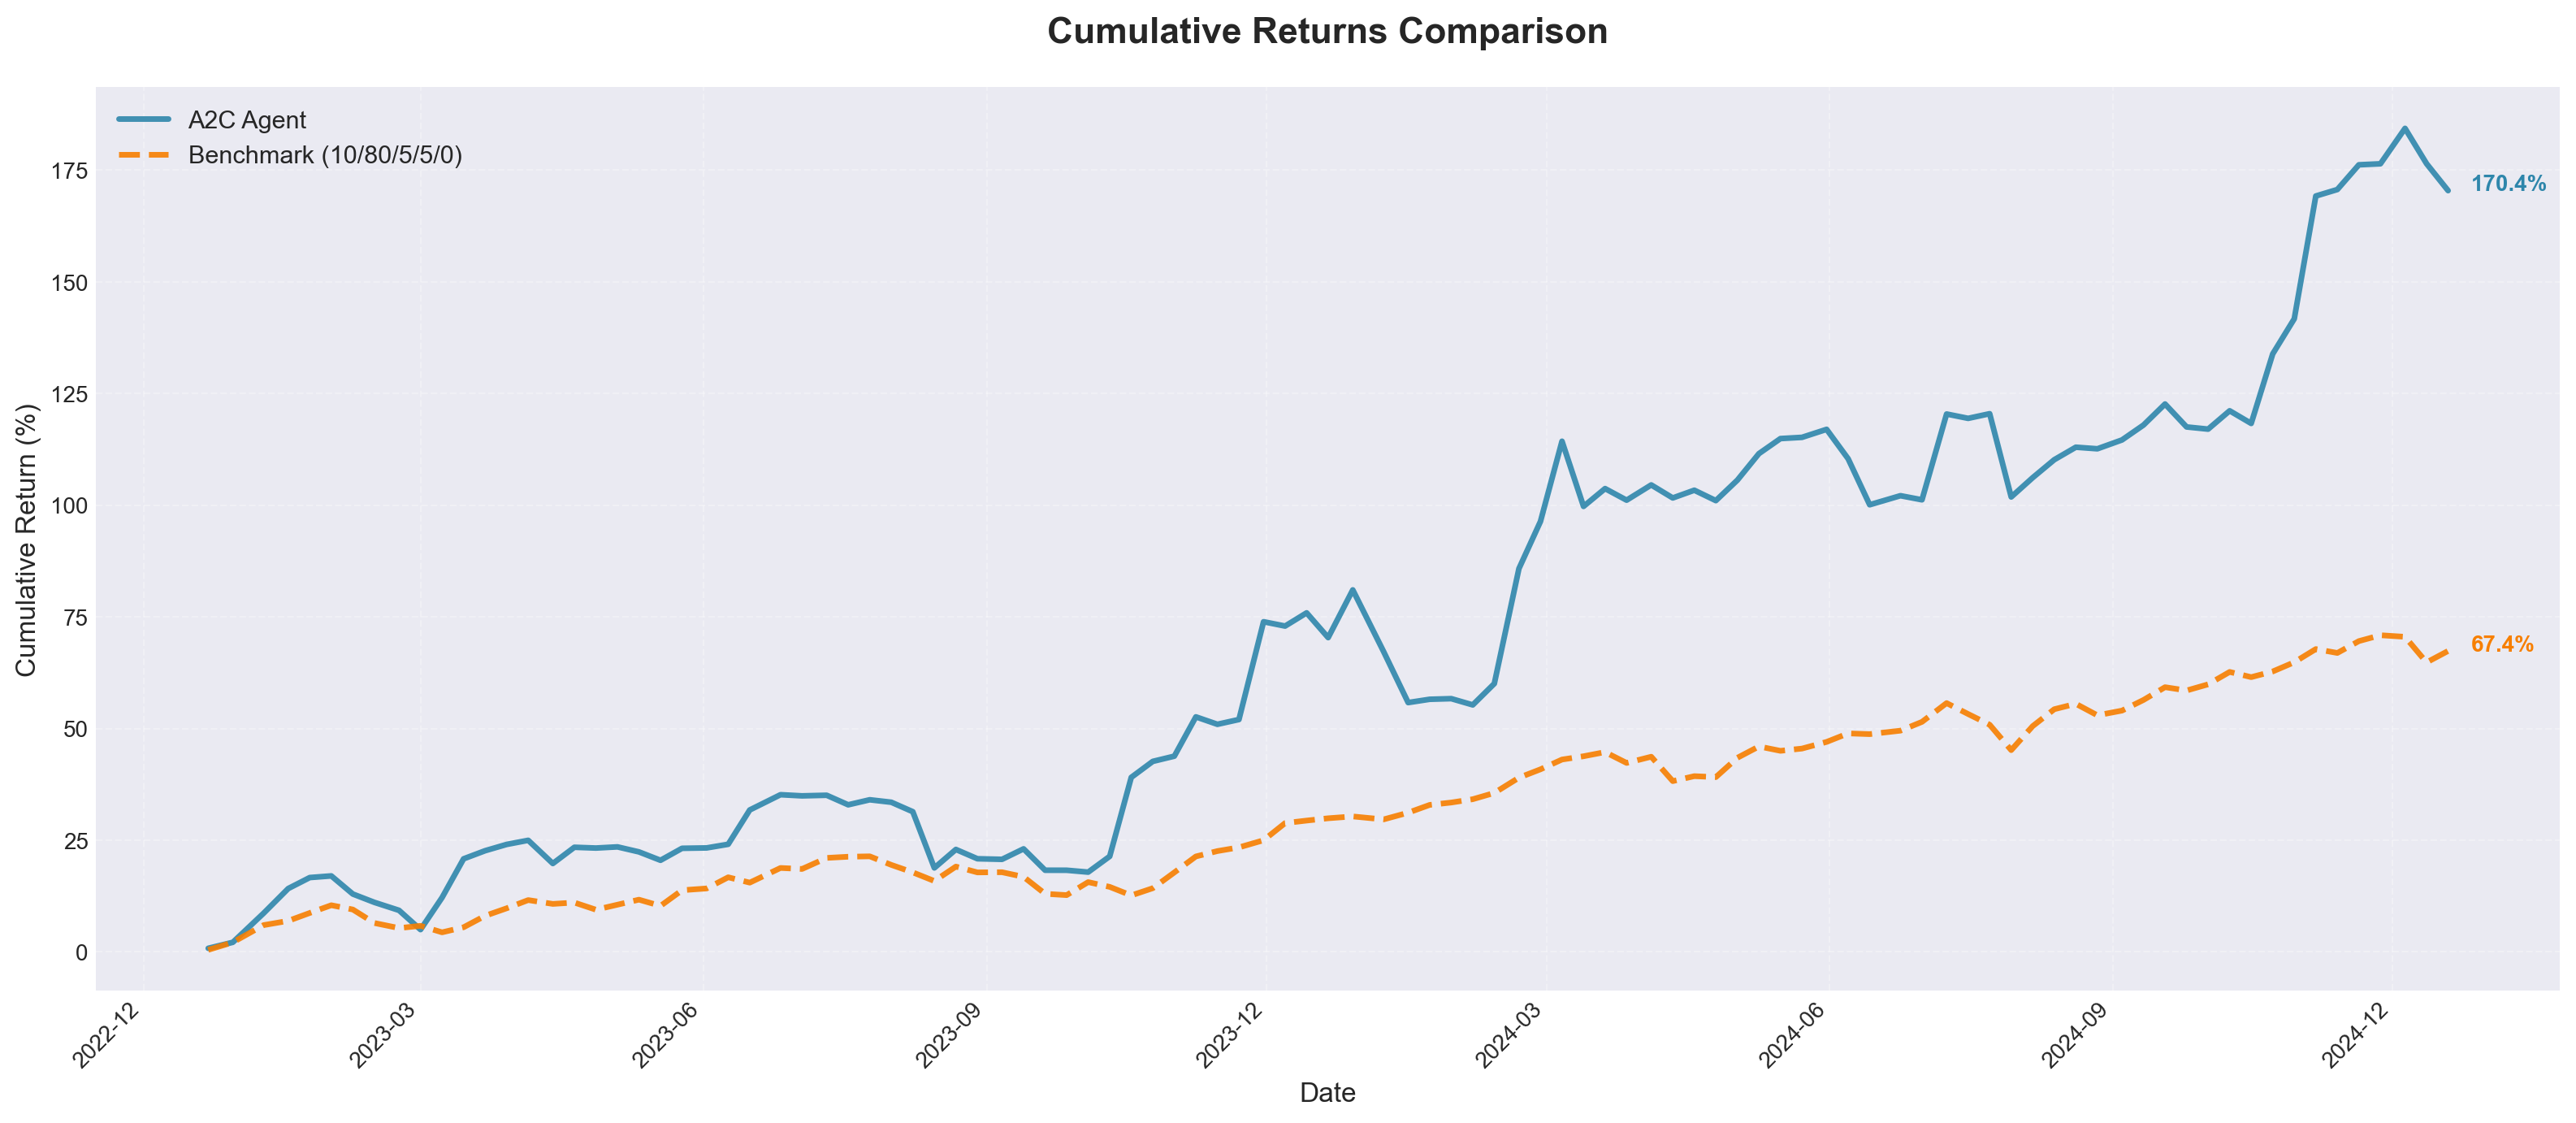

✓ Evaluation period: 2022-12-22 to 2024-12-19
  Total span: 728 calendar days
  Trading days covered: 505 out of 512

Final A2C cumulative return: 170.43%
Final Benchmark cumulative return: 67.36%
Outperformance: +103.07%


In [31]:
fig, ax = plt.subplots(figsize=(16, 7))

# CORRECT: Get dates at actual evaluation positions (every 5th day starting from position 5)
eval_positions = [5 + i * 5 for i in range(len(a2c_cumulative))]
eval_dates = df_test.index[eval_positions]

# Convert to percentage returns
a2c_cumulative_pct = (a2c_cumulative - 1) * 100
benchmark_cumulative_pct = (benchmark_cumulative - 1) * 100

ax.plot(eval_dates, a2c_cumulative_pct, label='A2C Agent', 
        linewidth=2.5, color='#2E86AB', alpha=0.9)
ax.plot(eval_dates, benchmark_cumulative_pct, label='Benchmark (10/80/5/5/0)', 
        linewidth=2.5, linestyle='--', color='#F77F00', alpha=0.9)

ax.set_title('Cumulative Returns Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

# Better date formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Annotations
final_a2c_pct = a2c_cumulative_pct[-1]
final_bench_pct = benchmark_cumulative_pct[-1]

ax.annotate(f'{final_a2c_pct:.1f}%', 
            xy=(eval_dates[-1], final_a2c_pct), 
            xytext=(10, 0), textcoords='offset points',
            fontsize=10, color='#2E86AB', fontweight='bold')
ax.annotate(f'{final_bench_pct:.1f}%', 
            xy=(eval_dates[-1], final_bench_pct), 
            xytext=(10, 0), textcoords='offset points',
            fontsize=10, color='#F77F00', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ Evaluation period: {eval_dates[0].strftime('%Y-%m-%d')} to {eval_dates[-1].strftime('%Y-%m-%d')}")
print(f"  Total span: {(eval_dates[-1] - eval_dates[0]).days} calendar days")
print(f"  Trading days covered: {eval_positions[-1]} out of {len(df_test)}")
print(f"\nFinal A2C cumulative return: {final_a2c_pct:.2f}%")
print(f"Final Benchmark cumulative return: {final_bench_pct:.2f}%")
print(f"Outperformance: {final_a2c_pct - final_bench_pct:+.2f}%")

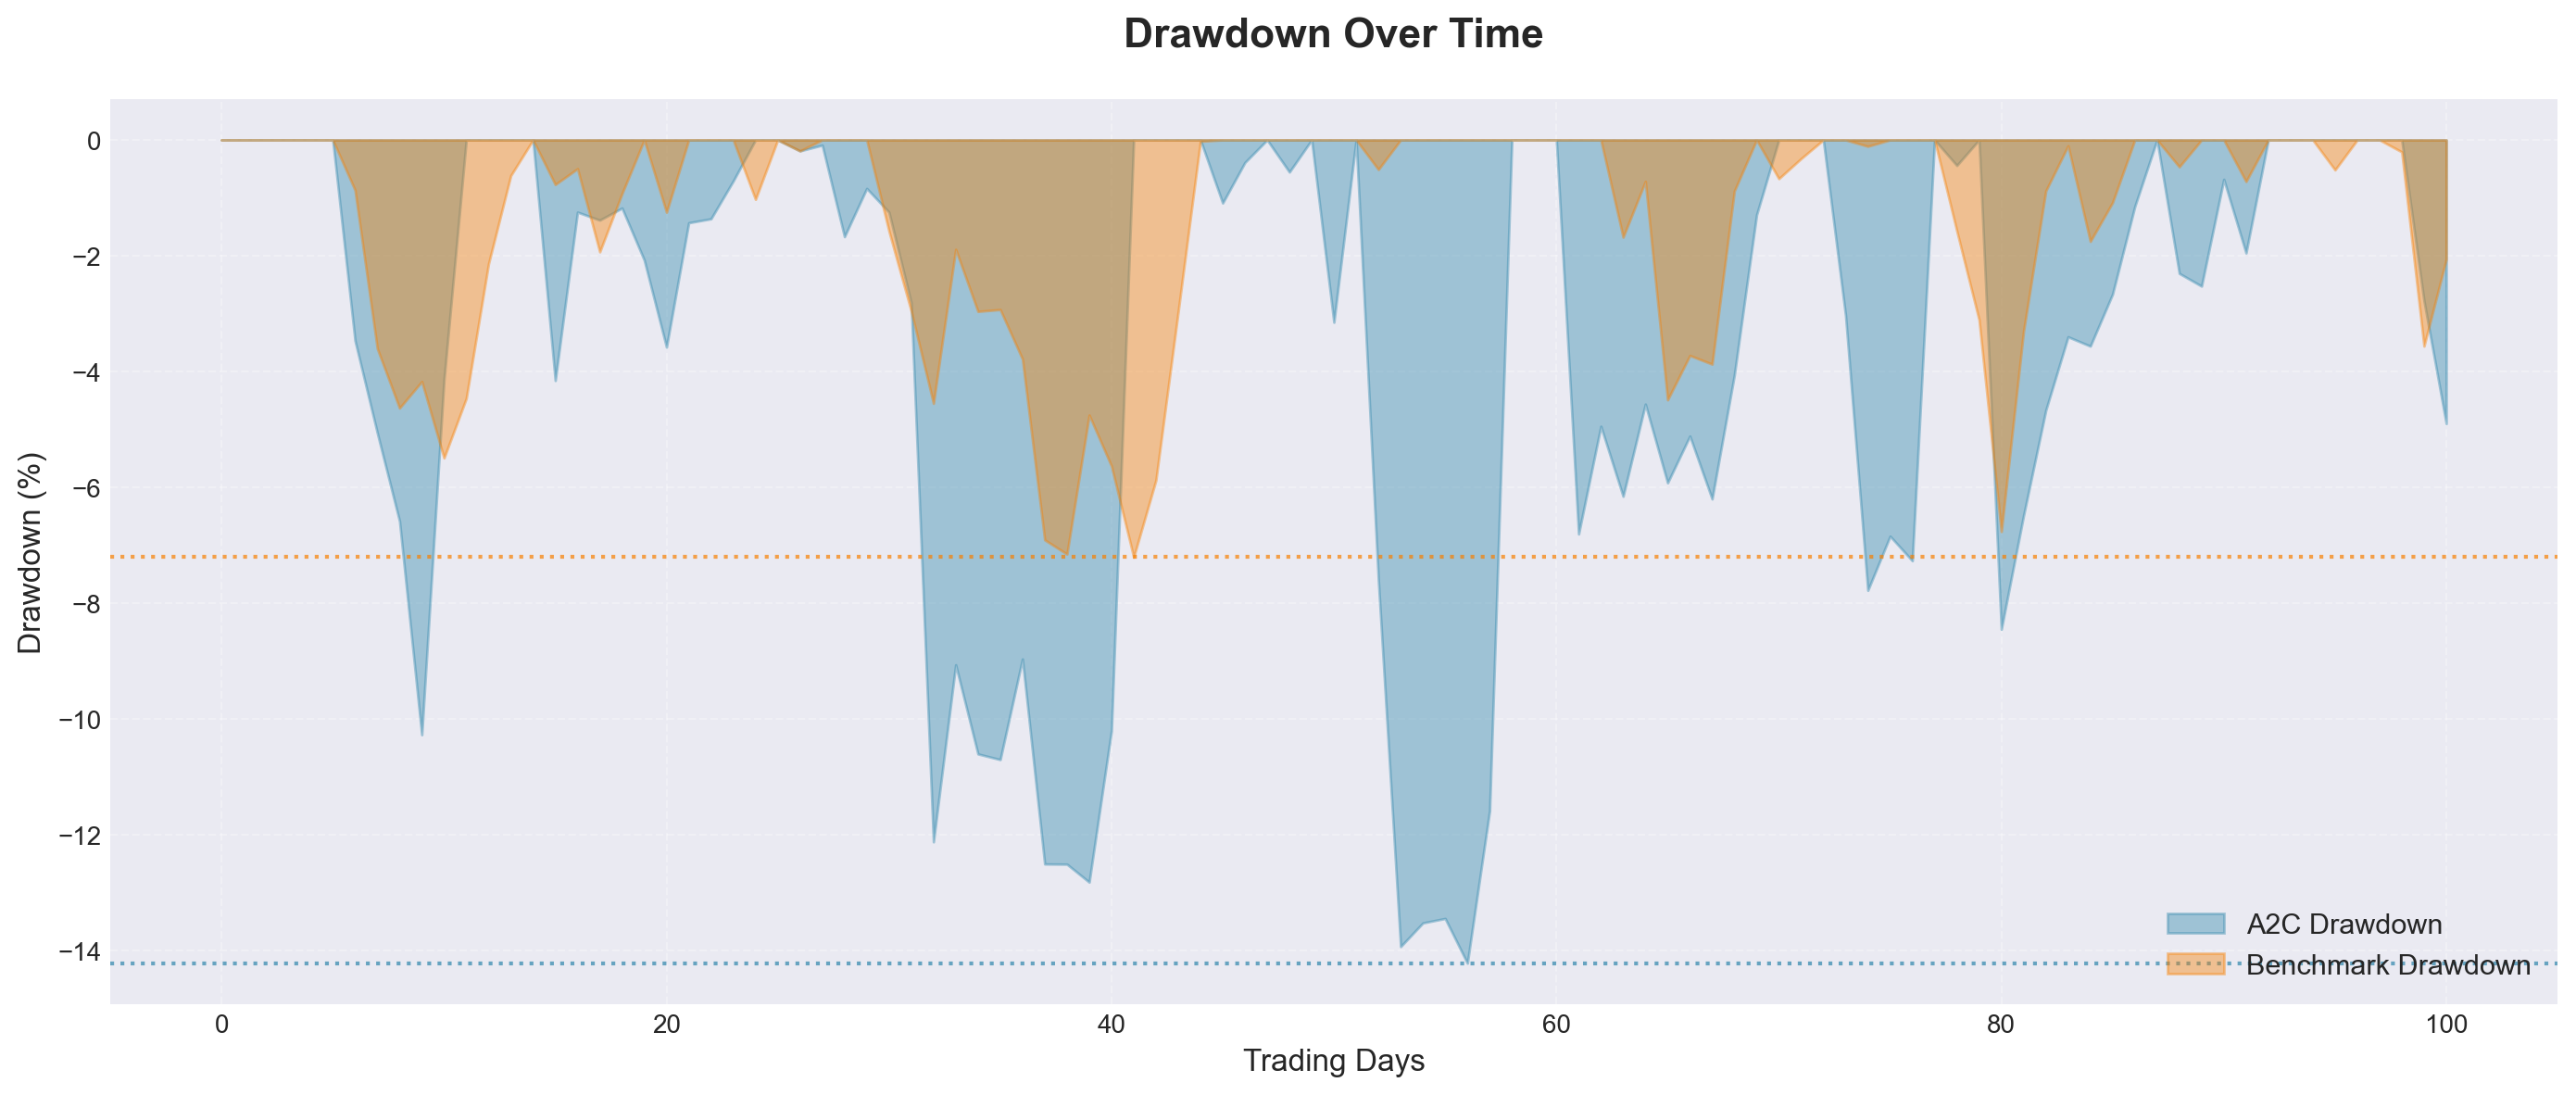

A2C Max Drawdown: -14.22%
Benchmark Max Drawdown: -7.21%


In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(range(len(a2c_drawdown)), a2c_drawdown*100, 0, 
                 alpha=0.4, label='A2C Drawdown', color='#2E86AB')
ax.fill_between(range(len(benchmark_drawdown)), benchmark_drawdown*100, 0, 
                 alpha=0.4, label='Benchmark Drawdown', color='#F77F00')

ax.set_title('Drawdown Over Time', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# Annotate max drawdowns
ax.axhline(y=a2c_max_drawdown*100, color='#2E86AB', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axhline(y=benchmark_max_drawdown*100, color='#F77F00', linestyle=':', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"A2C Max Drawdown: {a2c_max_drawdown*100:.2f}%")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown*100:.2f}%")

### **Portfolio Weights Changes**

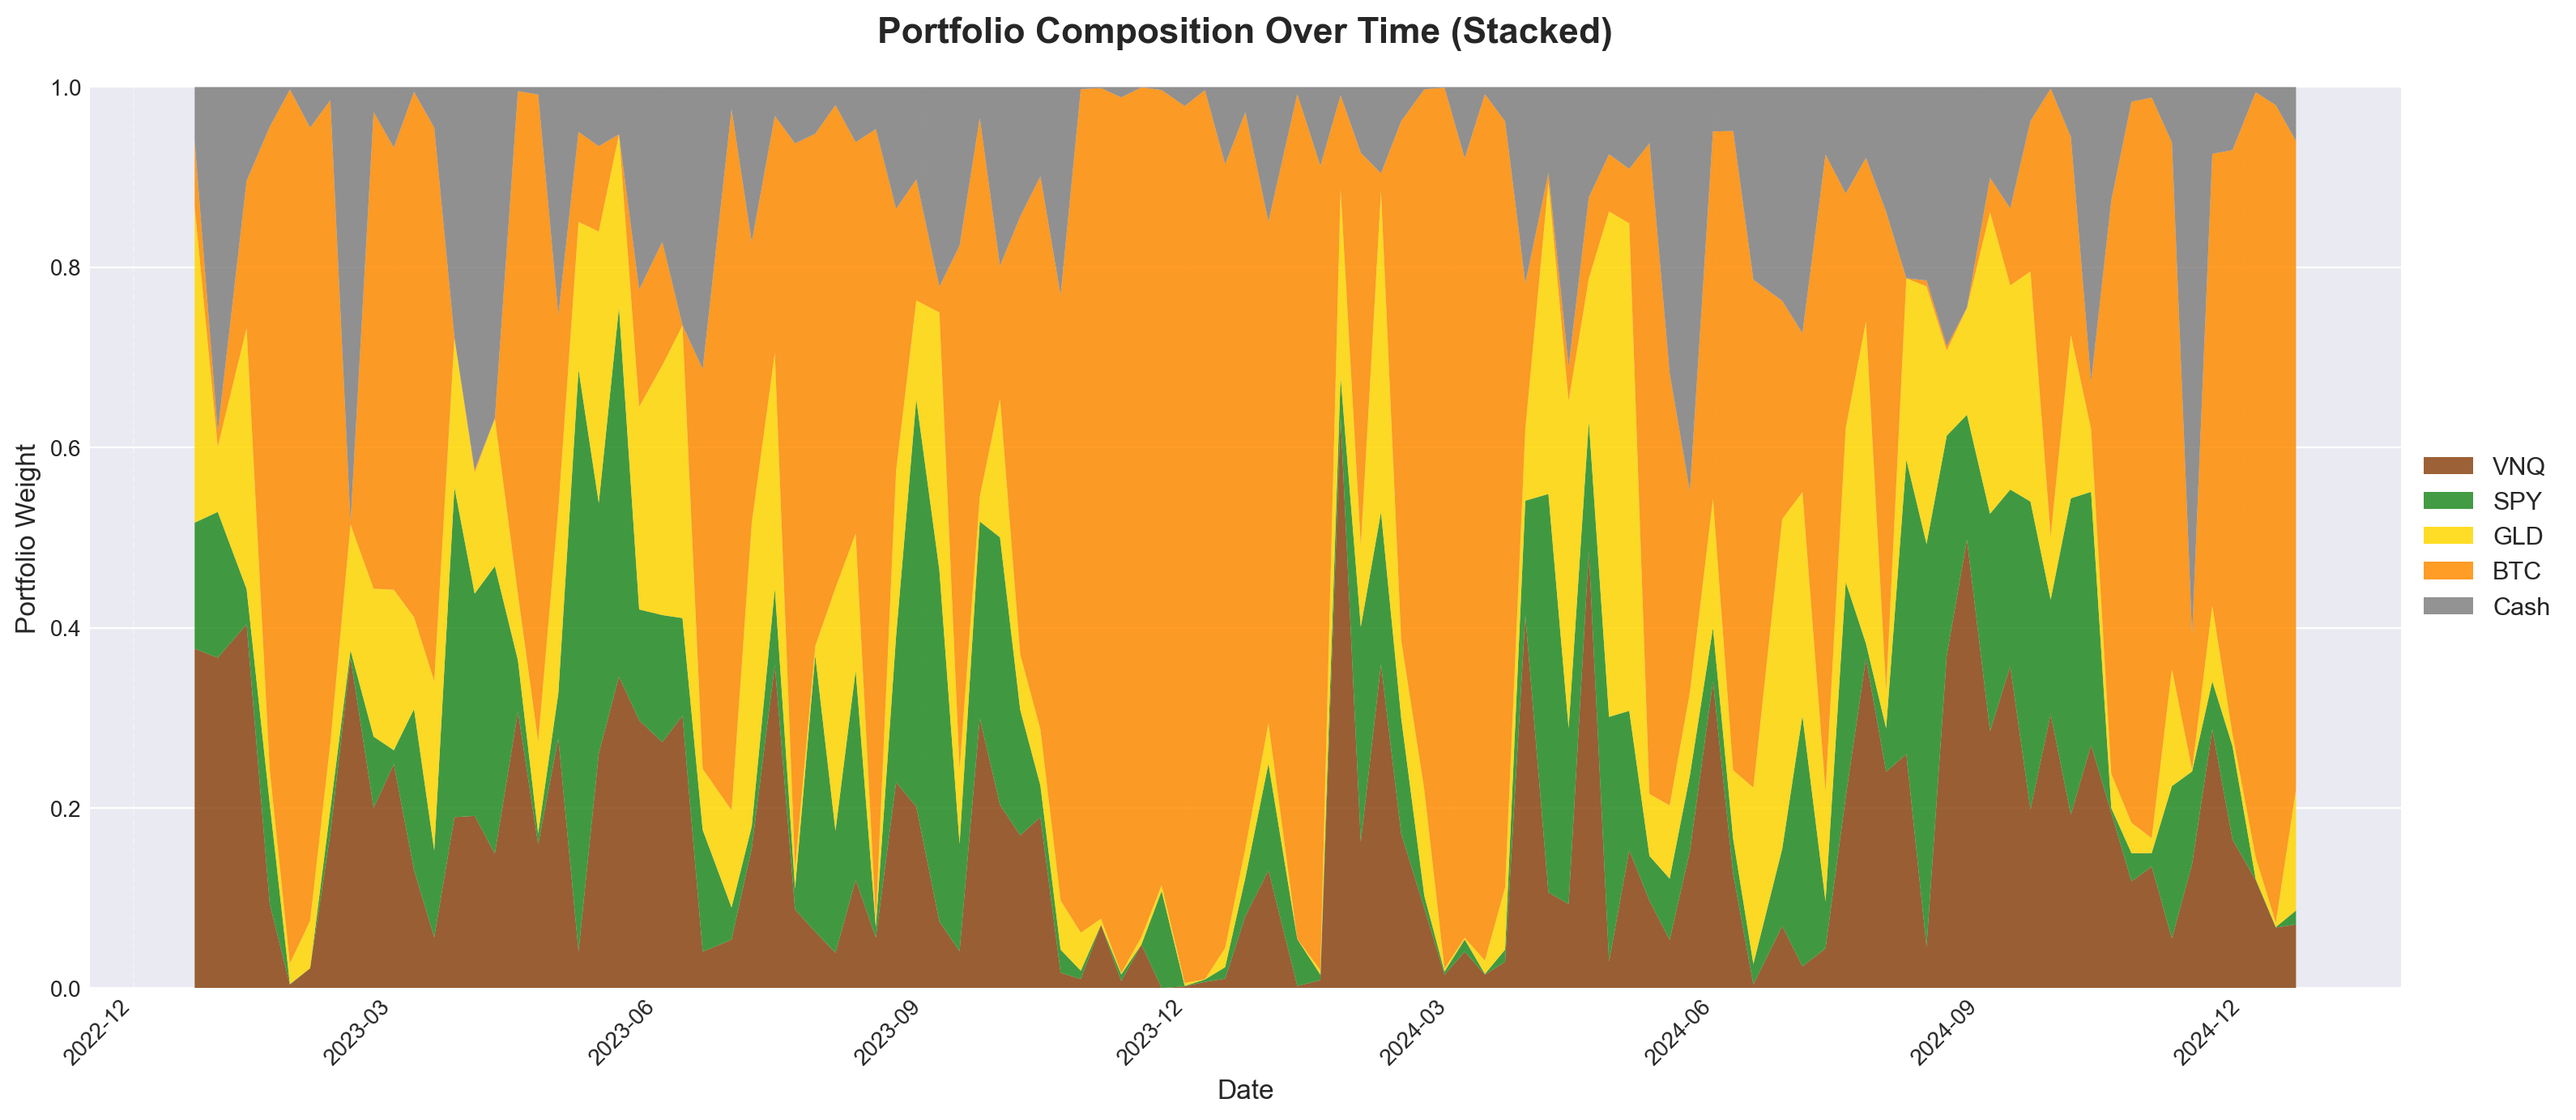

Average Portfolio Weights:
   VNQ:  16.51%
   SPY:  12.87%
   GLD:  13.57%
   BTC:  45.21%
  Cash:  11.84%

✓ Portfolio rebalanced every 5 days from 2022-12-22 to 2024-12-19


In [38]:
fig, ax = plt.subplots(figsize=(16, 7))

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

colors = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']

# Stacked area plot
ax.stackplot(eval_dates, 
             a2c_actions[:, 0], a2c_actions[:, 1], a2c_actions[:, 2], 
             a2c_actions[:, 3], a2c_actions[:, 4],
             labels=asset_names, colors=colors, alpha=0.85)

ax.set_title('Portfolio Composition Over Time (Stacked)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Weight', fontsize=12)

# FIXED: Move legend outside plot area
ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(1, 0.5), 
          framealpha=1, edgecolor='black', fancybox=True)

ax.set_ylim([0, 1])

# Format dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.show()

print("Average Portfolio Weights:")
print("="*50)
for name, weight in zip(asset_names, a2c_avg_weights):
    print(f"  {name:>4}: {weight*100:>6.2f}%")
    
print(f"\n✓ Portfolio rebalanced every 5 days from {eval_dates[0].strftime('%Y-%m-%d')} to {eval_dates[-1].strftime('%Y-%m-%d')}")

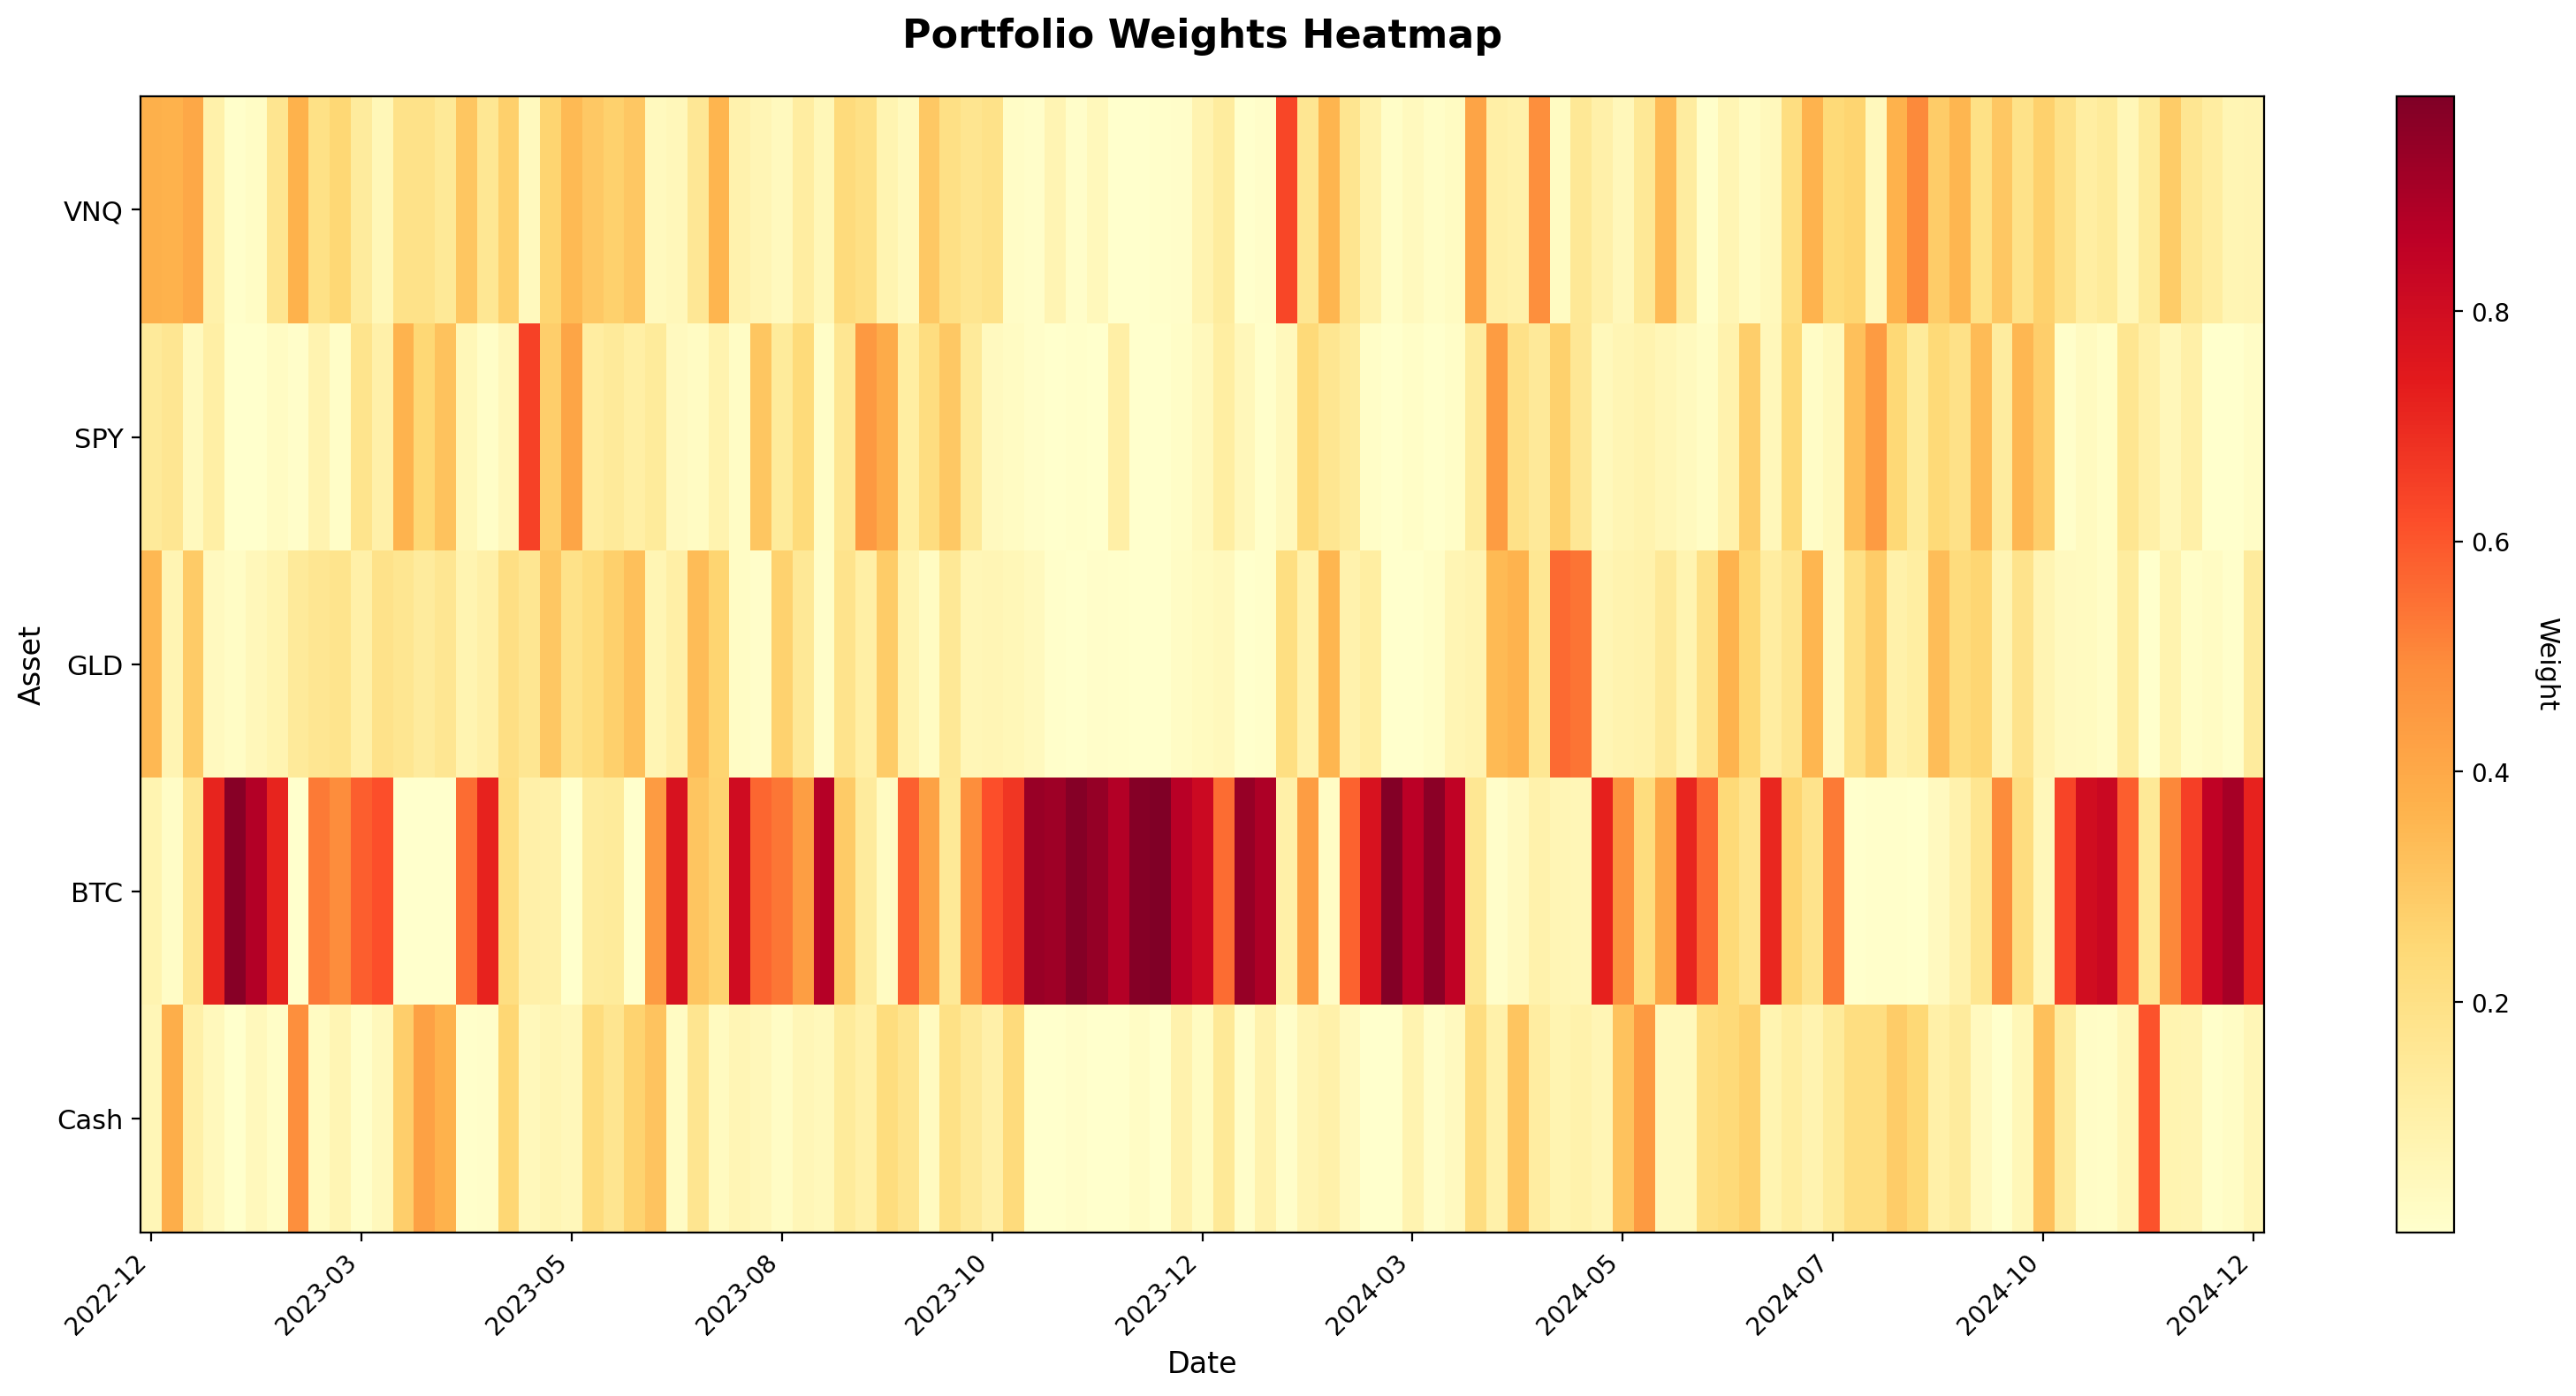

✓ Heatmap shows intensity of allocation
  Brighter colors = higher weight
  Darker colors = lower weight


In [41]:
## 🎯 Alternative 2: Heatmap

import matplotlib.dates as mdates
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(16, 8))

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']

# Create heatmap (transpose so assets are rows, time is columns)
im = ax.imshow(a2c_actions.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')

# Set ticks
ax.set_yticks(range(len(asset_names)))
ax.set_yticklabels(asset_names, fontsize=11)

# X-axis: Show every 10th date to avoid crowding
step = max(1, len(eval_dates) // 10)
x_positions = range(0, len(eval_dates), step)
ax.set_xticks(x_positions)
ax.set_xticklabels([eval_dates[i].strftime('%Y-%m') for i in x_positions], 
                    rotation=45, ha='right')

ax.set_title('Portfolio Weights Heatmap', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Asset', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Weight', rotation=270, labelpad=20, fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Heatmap shows intensity of allocation")
print("  Brighter colors = higher weight")
print("  Darker colors = lower weight")

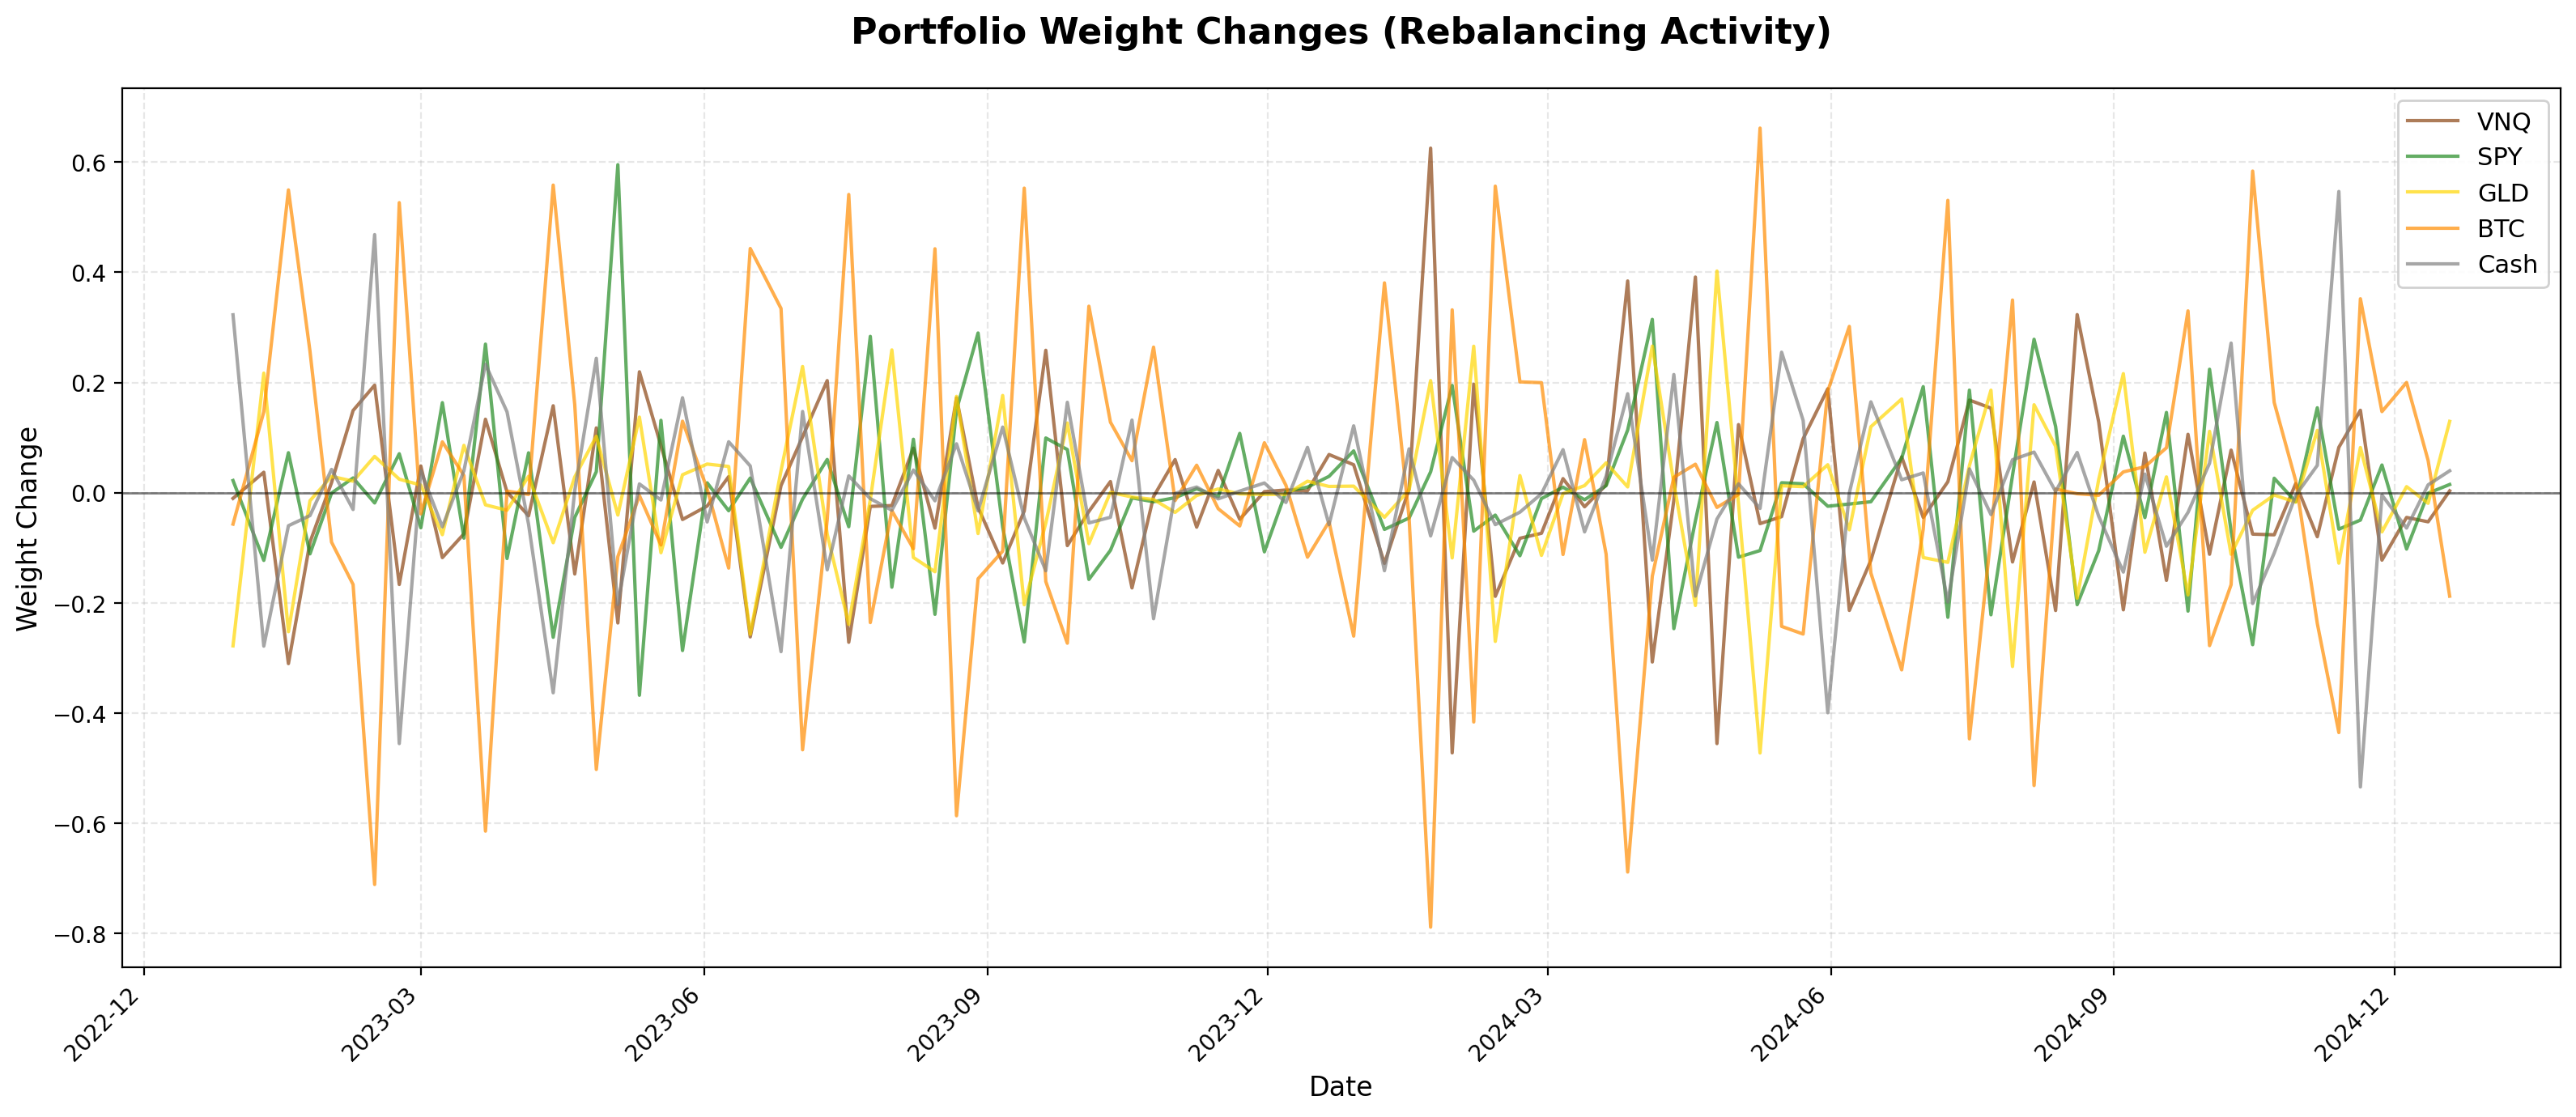

✓ Weight changes show rebalancing activity
  Average turnover per rebalancing: 65.46%
  Max turnover: 173.36%
  Min turnover: 4.11%


In [42]:
## 🎯 Alternative 3: Portfolio Changes Over Time

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 7))

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

# Calculate changes (differences between consecutive periods)
weight_changes = np.diff(a2c_actions, axis=0)

colors = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']

for i, (name, color) in enumerate(zip(asset_names, colors)):
    ax.plot(eval_dates[1:], weight_changes[:, i], label=name, 
            linewidth=1.5, color=color, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_title('Portfolio Weight Changes (Rebalancing Activity)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weight Change', fontsize=12)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Format dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Calculate turnover (sum of absolute changes)
turnover = np.sum(np.abs(weight_changes), axis=1)
avg_turnover = np.mean(turnover)

print("✓ Weight changes show rebalancing activity")
print(f"  Average turnover per rebalancing: {avg_turnover*100:.2f}%")
print(f"  Max turnover: {np.max(turnover)*100:.2f}%")
print(f"  Min turnover: {np.min(turnover)*100:.2f}%")

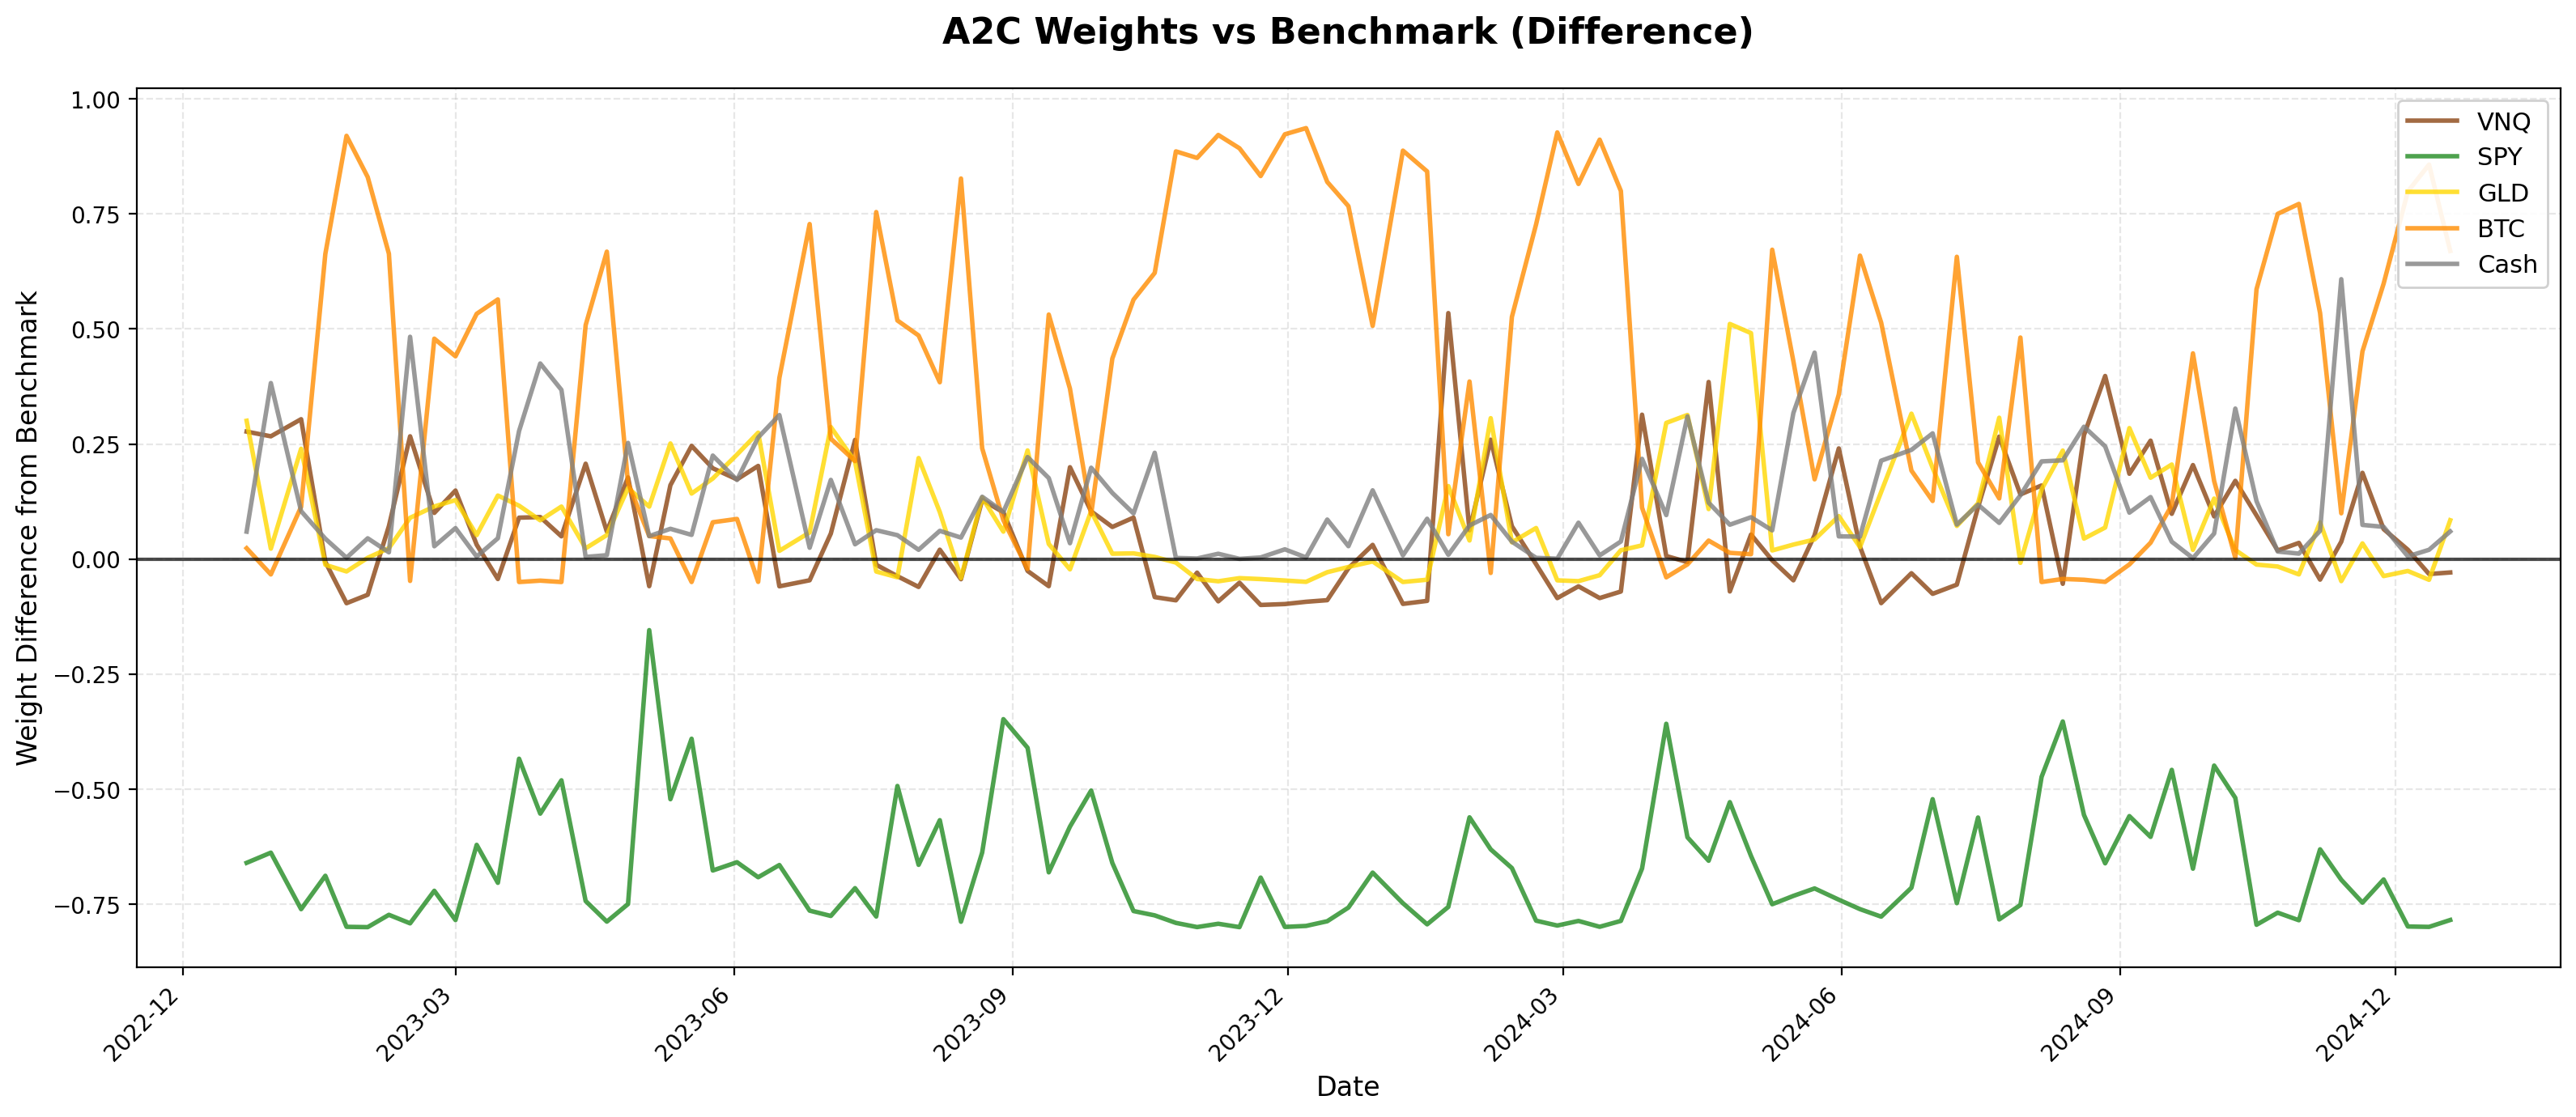

✓ Shows how A2C deviates from benchmark allocation
  Positive = overweight vs benchmark
  Negative = underweight vs benchmark

Benchmark: VNQ=10%, SPY=80%, GLD=5%, BTC=5%, Cash=0%


In [43]:
## 🎯 Alternative 4: Difference from Benchmark

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 7))

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

# Benchmark weights (constant)
benchmark_weights = np.array([0.1, 0.8, 0.05, 0.05, 0])

# Calculate difference from benchmark
diff_from_benchmark = a2c_actions - benchmark_weights[np.newaxis, :]

colors = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']

for i, (name, color) in enumerate(zip(asset_names, colors)):
    ax.plot(eval_dates, diff_from_benchmark[:, i], label=name, 
            linewidth=2, color=color, alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax.set_title('A2C Weights vs Benchmark (Difference)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weight Difference from Benchmark', fontsize=12)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Format dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✓ Shows how A2C deviates from benchmark allocation")
print("  Positive = overweight vs benchmark")
print("  Negative = underweight vs benchmark")
print(f"\nBenchmark: VNQ={benchmark_weights[0]:.0%}, SPY={benchmark_weights[1]:.0%}, "
      f"GLD={benchmark_weights[2]:.0%}, BTC={benchmark_weights[3]:.0%}, Cash={benchmark_weights[4]:.0%}")

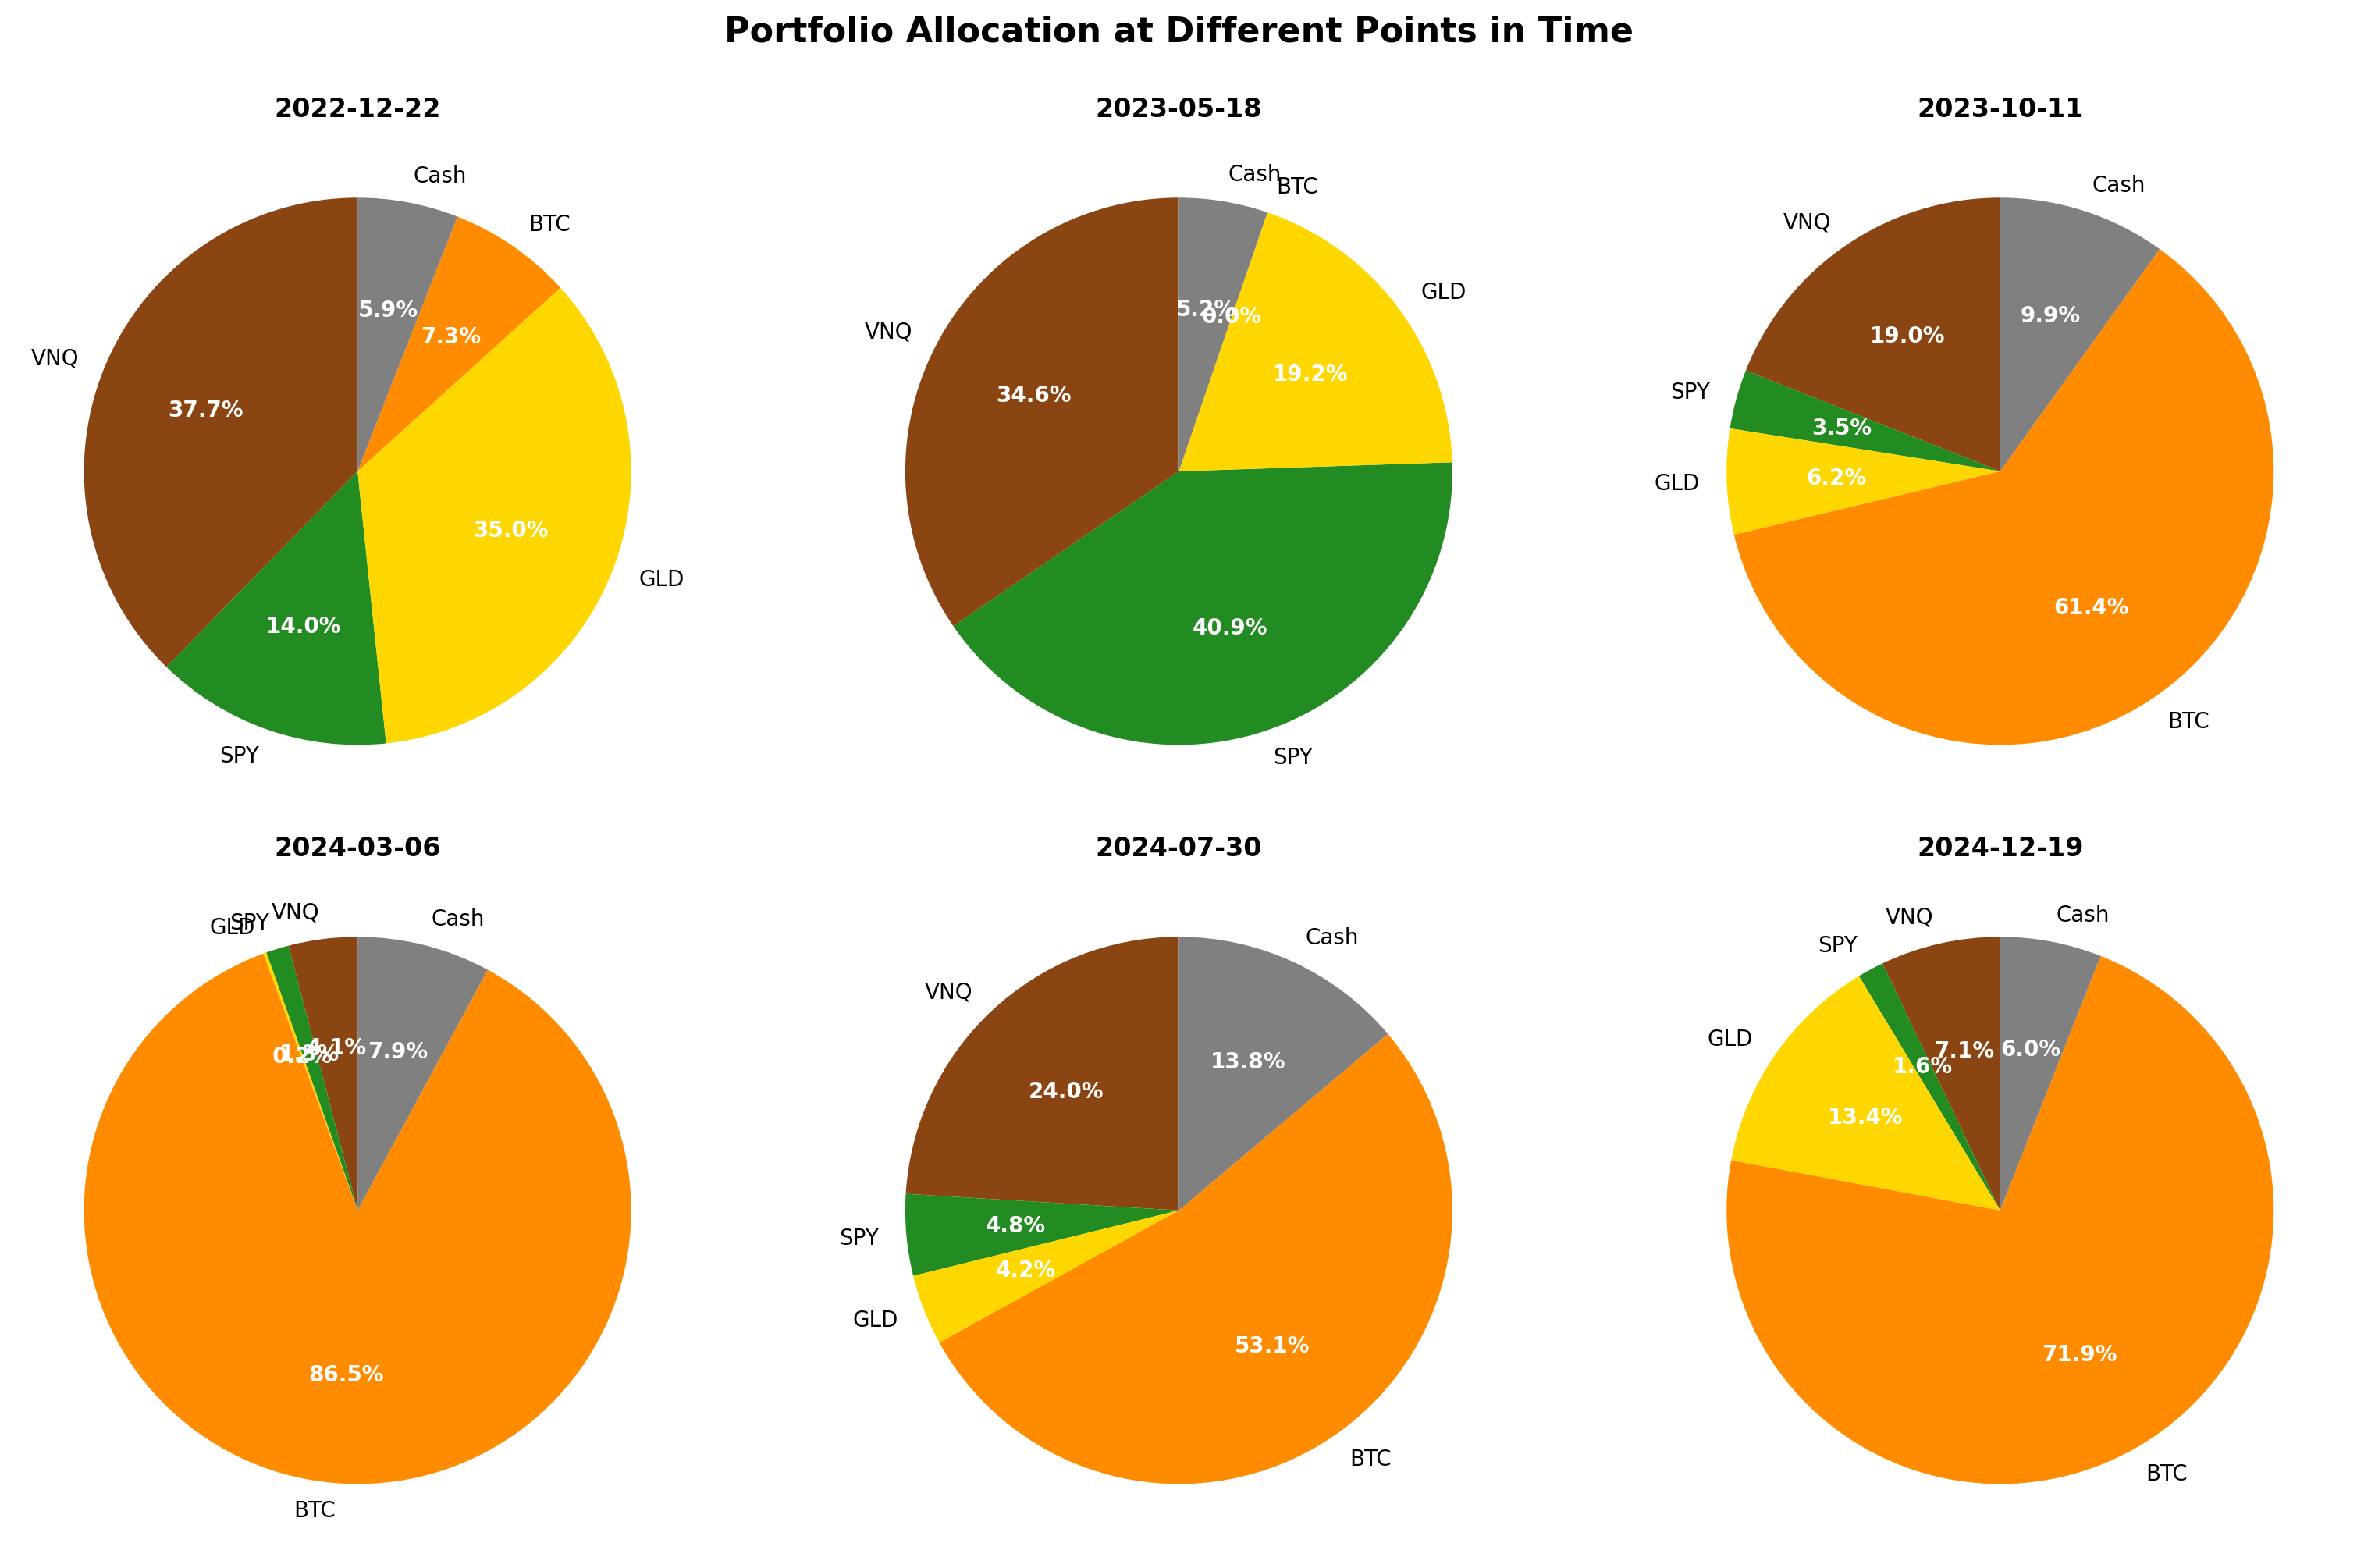

✓ Pie charts show portfolio composition at 6 key dates
  Visualizes how allocation strategy evolved


In [44]:
## 🎯 Alternative 5: Portfolio Snapshots at Key Dates

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

# Select 6 key snapshots (beginning, middle, end, and 3 others)
snapshot_indices = [0, len(a2c_actions)//5, 2*len(a2c_actions)//5, 
                    3*len(a2c_actions)//5, 4*len(a2c_actions)//5, -1]

colors = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']

for idx, snapshot_idx in enumerate(snapshot_indices):
    ax = axes[idx]
    weights = a2c_actions[snapshot_idx]
    date = eval_dates[snapshot_idx]
    
    # Pie chart
    wedges, texts, autotexts = ax.pie(weights, labels=asset_names, autopct='%1.1f%%',
                                        colors=colors, startangle=90)
    
    # Make percentage text bold and white
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax.set_title(f"{date.strftime('%Y-%m-%d')}", fontsize=12, fontweight='bold')

plt.suptitle('Portfolio Allocation at Different Points in Time', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Pie charts show portfolio composition at 6 key dates")
print("  Visualizes how allocation strategy evolved")

### **Transaction Costs Analysis**

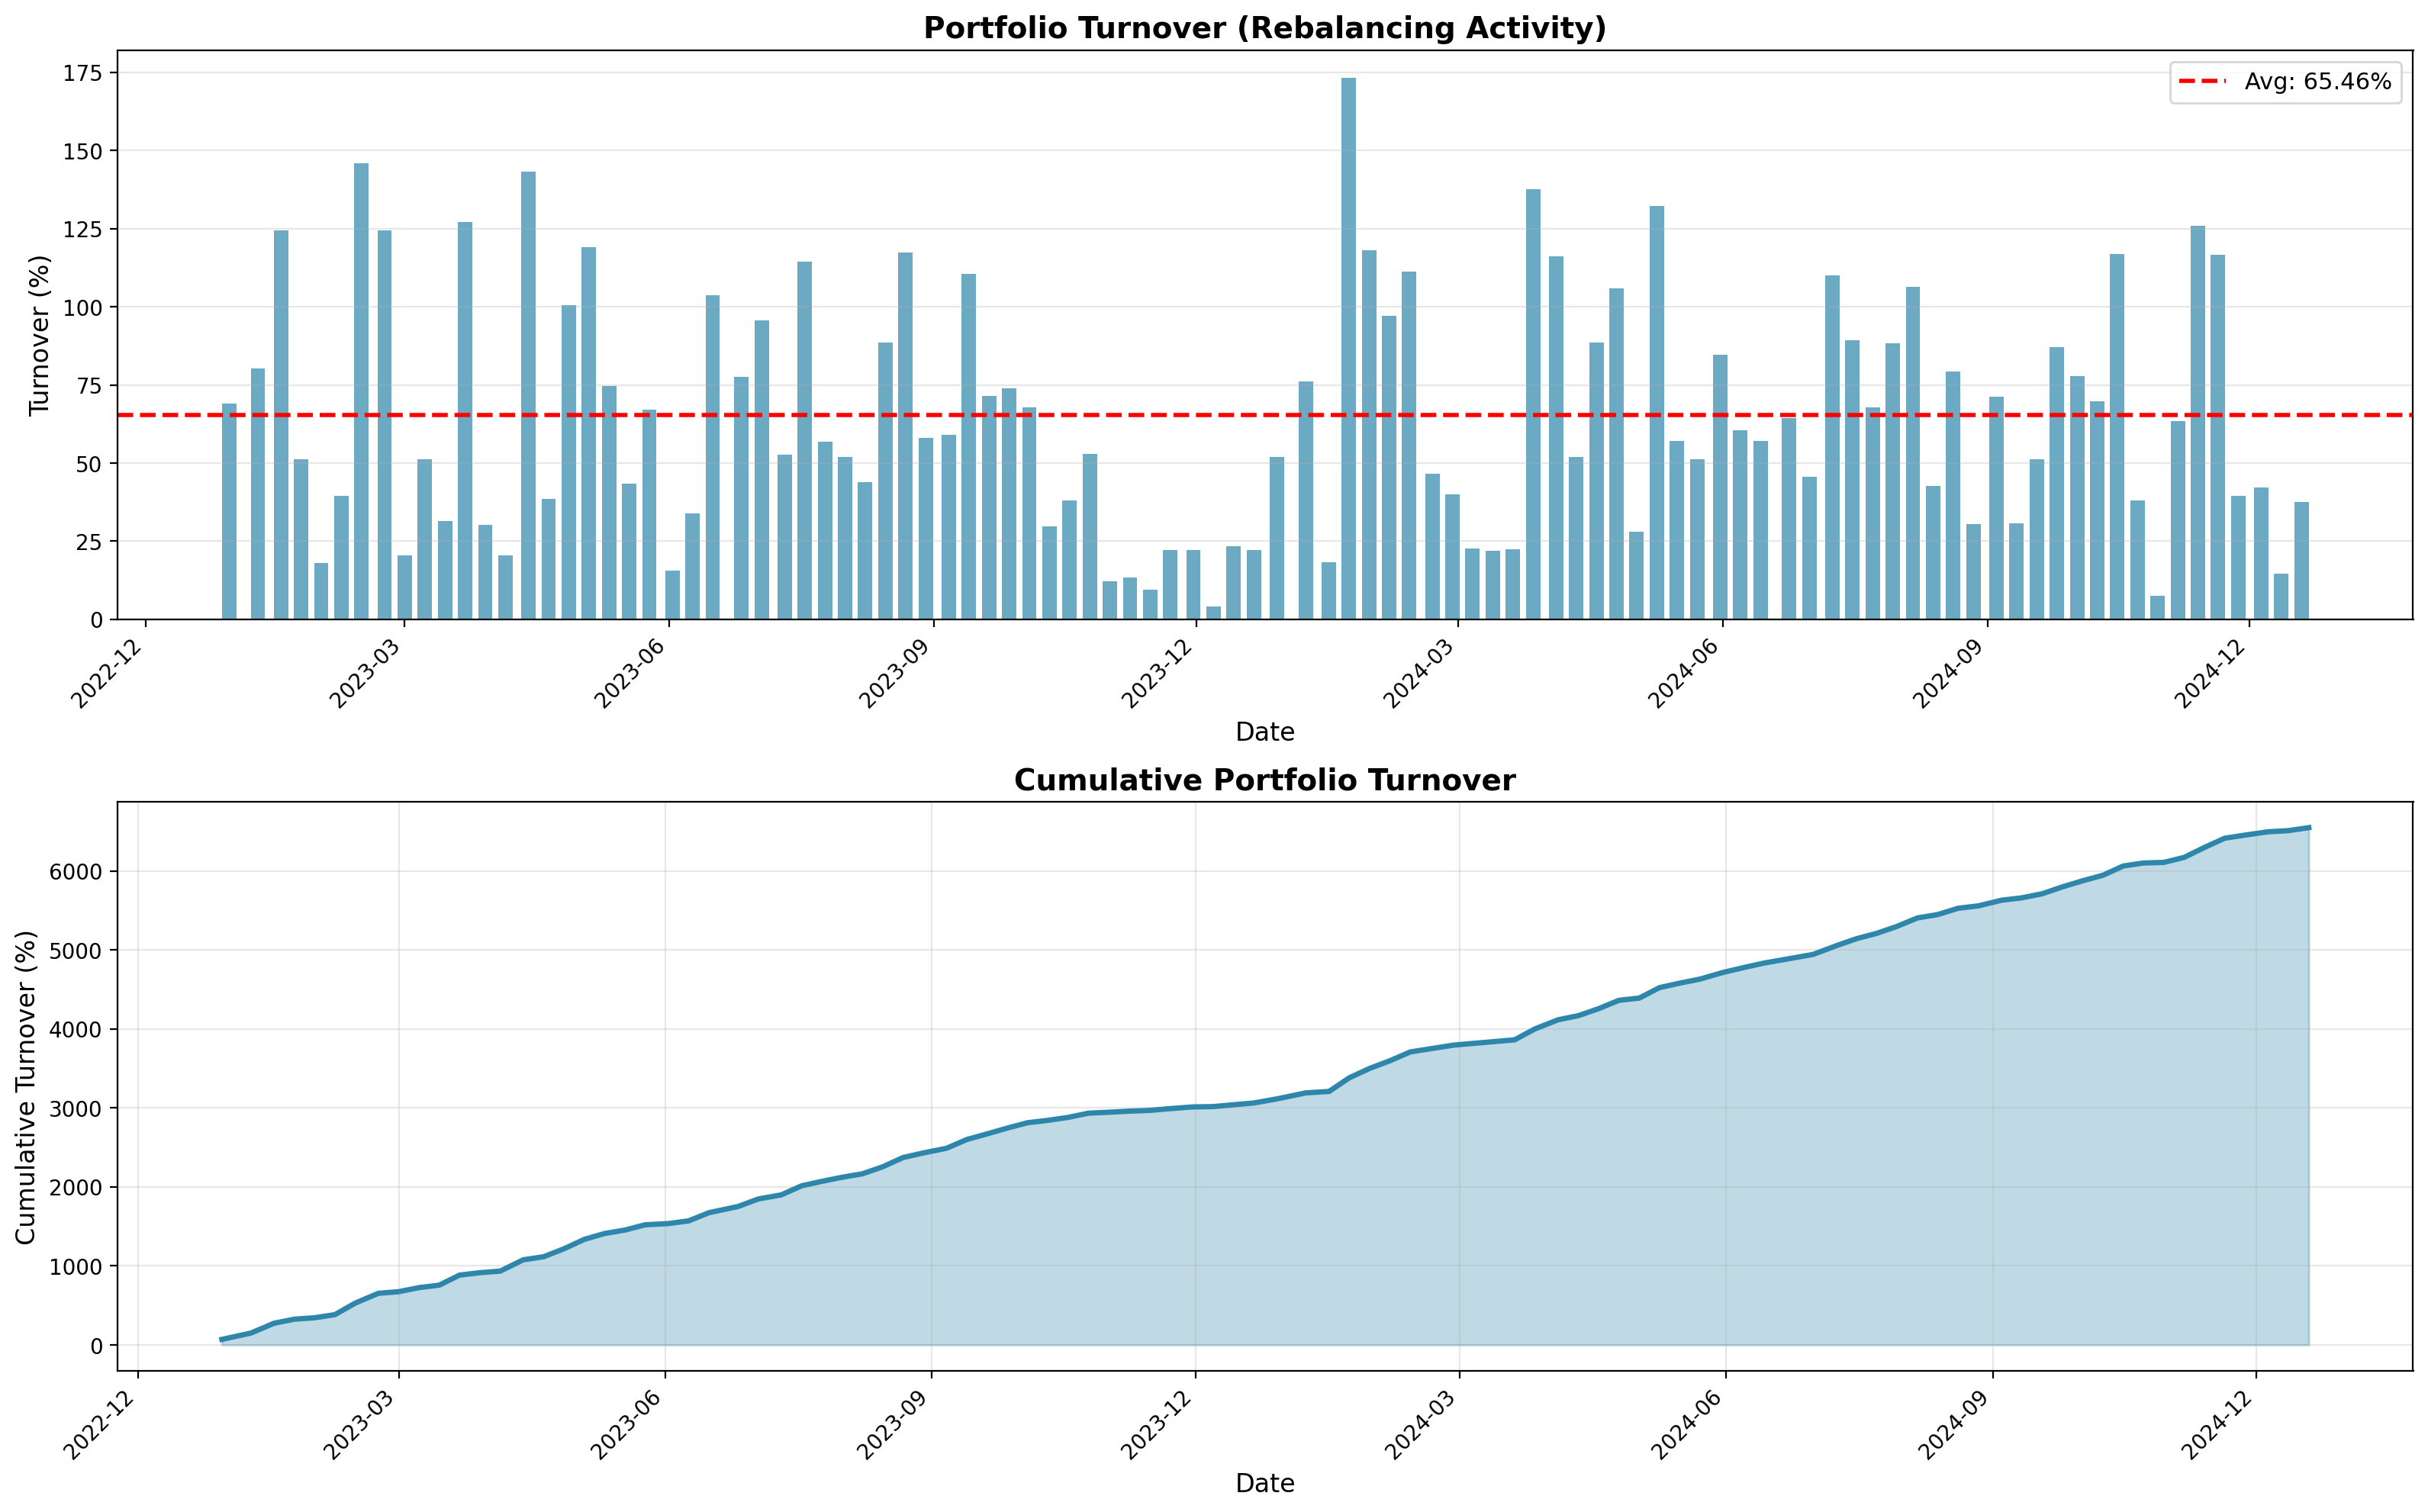

Portfolio Turnover Statistics:
Average turnover per rebalancing: 65.46%
Total cumulative turnover: 6546.48%
Max single period turnover: 173.36%
Min single period turnover: 4.11%

✓ Lower turnover = less trading = lower transaction costs


In [45]:
## 🎯 Alternative 6: Portfolio Turnover Over Time

import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Get dates
eval_positions = [5 + i * 5 for i in range(len(a2c_actions))]
eval_dates = df_test.index[eval_positions]

# Calculate turnover (sum of absolute weight changes)
weight_changes = np.diff(a2c_actions, axis=0)
turnover = np.sum(np.abs(weight_changes), axis=1)

# Plot 1: Turnover over time
ax1.bar(eval_dates[1:], turnover*100, color='#2E86AB', alpha=0.7, width=5)
ax1.axhline(y=np.mean(turnover)*100, color='red', linestyle='--', 
            linewidth=2, label=f'Avg: {np.mean(turnover)*100:.2f}%')
ax1.set_title('Portfolio Turnover (Rebalancing Activity)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Turnover (%)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Format dates
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Cumulative turnover
cumulative_turnover = np.cumsum(turnover) * 100
ax2.plot(eval_dates[1:], cumulative_turnover, color='#2E86AB', linewidth=2.5)
ax2.fill_between(eval_dates[1:], 0, cumulative_turnover, alpha=0.3, color='#2E86AB')
ax2.set_title('Cumulative Portfolio Turnover', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Cumulative Turnover (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Format dates
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Portfolio Turnover Statistics:")
print("="*50)
print(f"Average turnover per rebalancing: {np.mean(turnover)*100:.2f}%")
print(f"Total cumulative turnover: {cumulative_turnover[-1]:.2f}%")
print(f"Max single period turnover: {np.max(turnover)*100:.2f}%")
print(f"Min single period turnover: {np.min(turnover)*100:.2f}%")
print(f"\n✓ Lower turnover = less trading = lower transaction costs")

In [50]:
TRANSACTION_COST_RATE = 0.001  # 0.1%

# Calculate costs
cost_per_rebalancing = np.mean(turnover) * TRANSACTION_COST_RATE
total_transaction_costs = cost_per_rebalancing * len(turnover)

print(f"Transaction Cost Analysis:")
print(f"  Cost rate: {TRANSACTION_COST_RATE*100}%")
print(f"  Cost per rebalancing: {cost_per_rebalancing*100:.3f}%")
print(f"  Total costs over {len(turnover)} rebalancing: {total_transaction_costs*100:.2f}%")

# Impact on returns
print(f"\nImpact on Performance:")
print(f"  A2C gross return: {a2c_total_return*100:.2f}%")
print(f"  Transaction costs: -{total_transaction_costs*100:.2f}%")
print(f"  A2C net return: {(a2c_total_return - total_transaction_costs)*100:.2f}%")
print(f"  Benchmark return: {benchmark_total_return*100:.2f}%")

net_outperformance = (a2c_total_return - total_transaction_costs) - benchmark_total_return
print(f"\nNet outperformance: {net_outperformance*100:+.2f}%")

Transaction Cost Analysis:
  Cost rate: 0.1%
  Cost per rebalancing: 0.065%
  Total costs over 100 rebalancing: 6.55%

Impact on Performance:
  A2C gross return: 170.43%
  Transaction costs: -6.55%
  A2C net return: 163.88%
  Benchmark return: 67.36%

Net outperformance: +96.52%


### **Rolling Metrics**

/var/folders/3v/2yw6c8qx0n55dsz1fdnrlrm80000gn/T/ipykernel_9103/1836791210.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_a2c = pd.Series(a2c_rewards, index=df_test.index[:len(a2c_rewards)]).resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
/var/folders/3v/2yw6c8qx0n55dsz1fdnrlrm80000gn/T/ipykernel_9103/1836791210.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_benchmark = pd.Series(benchmark_rewards, index=df_test.index[:len(benchmark_rewards)]).resample('M').apply(lambda x: (1 + x).prod() - 1) * 100


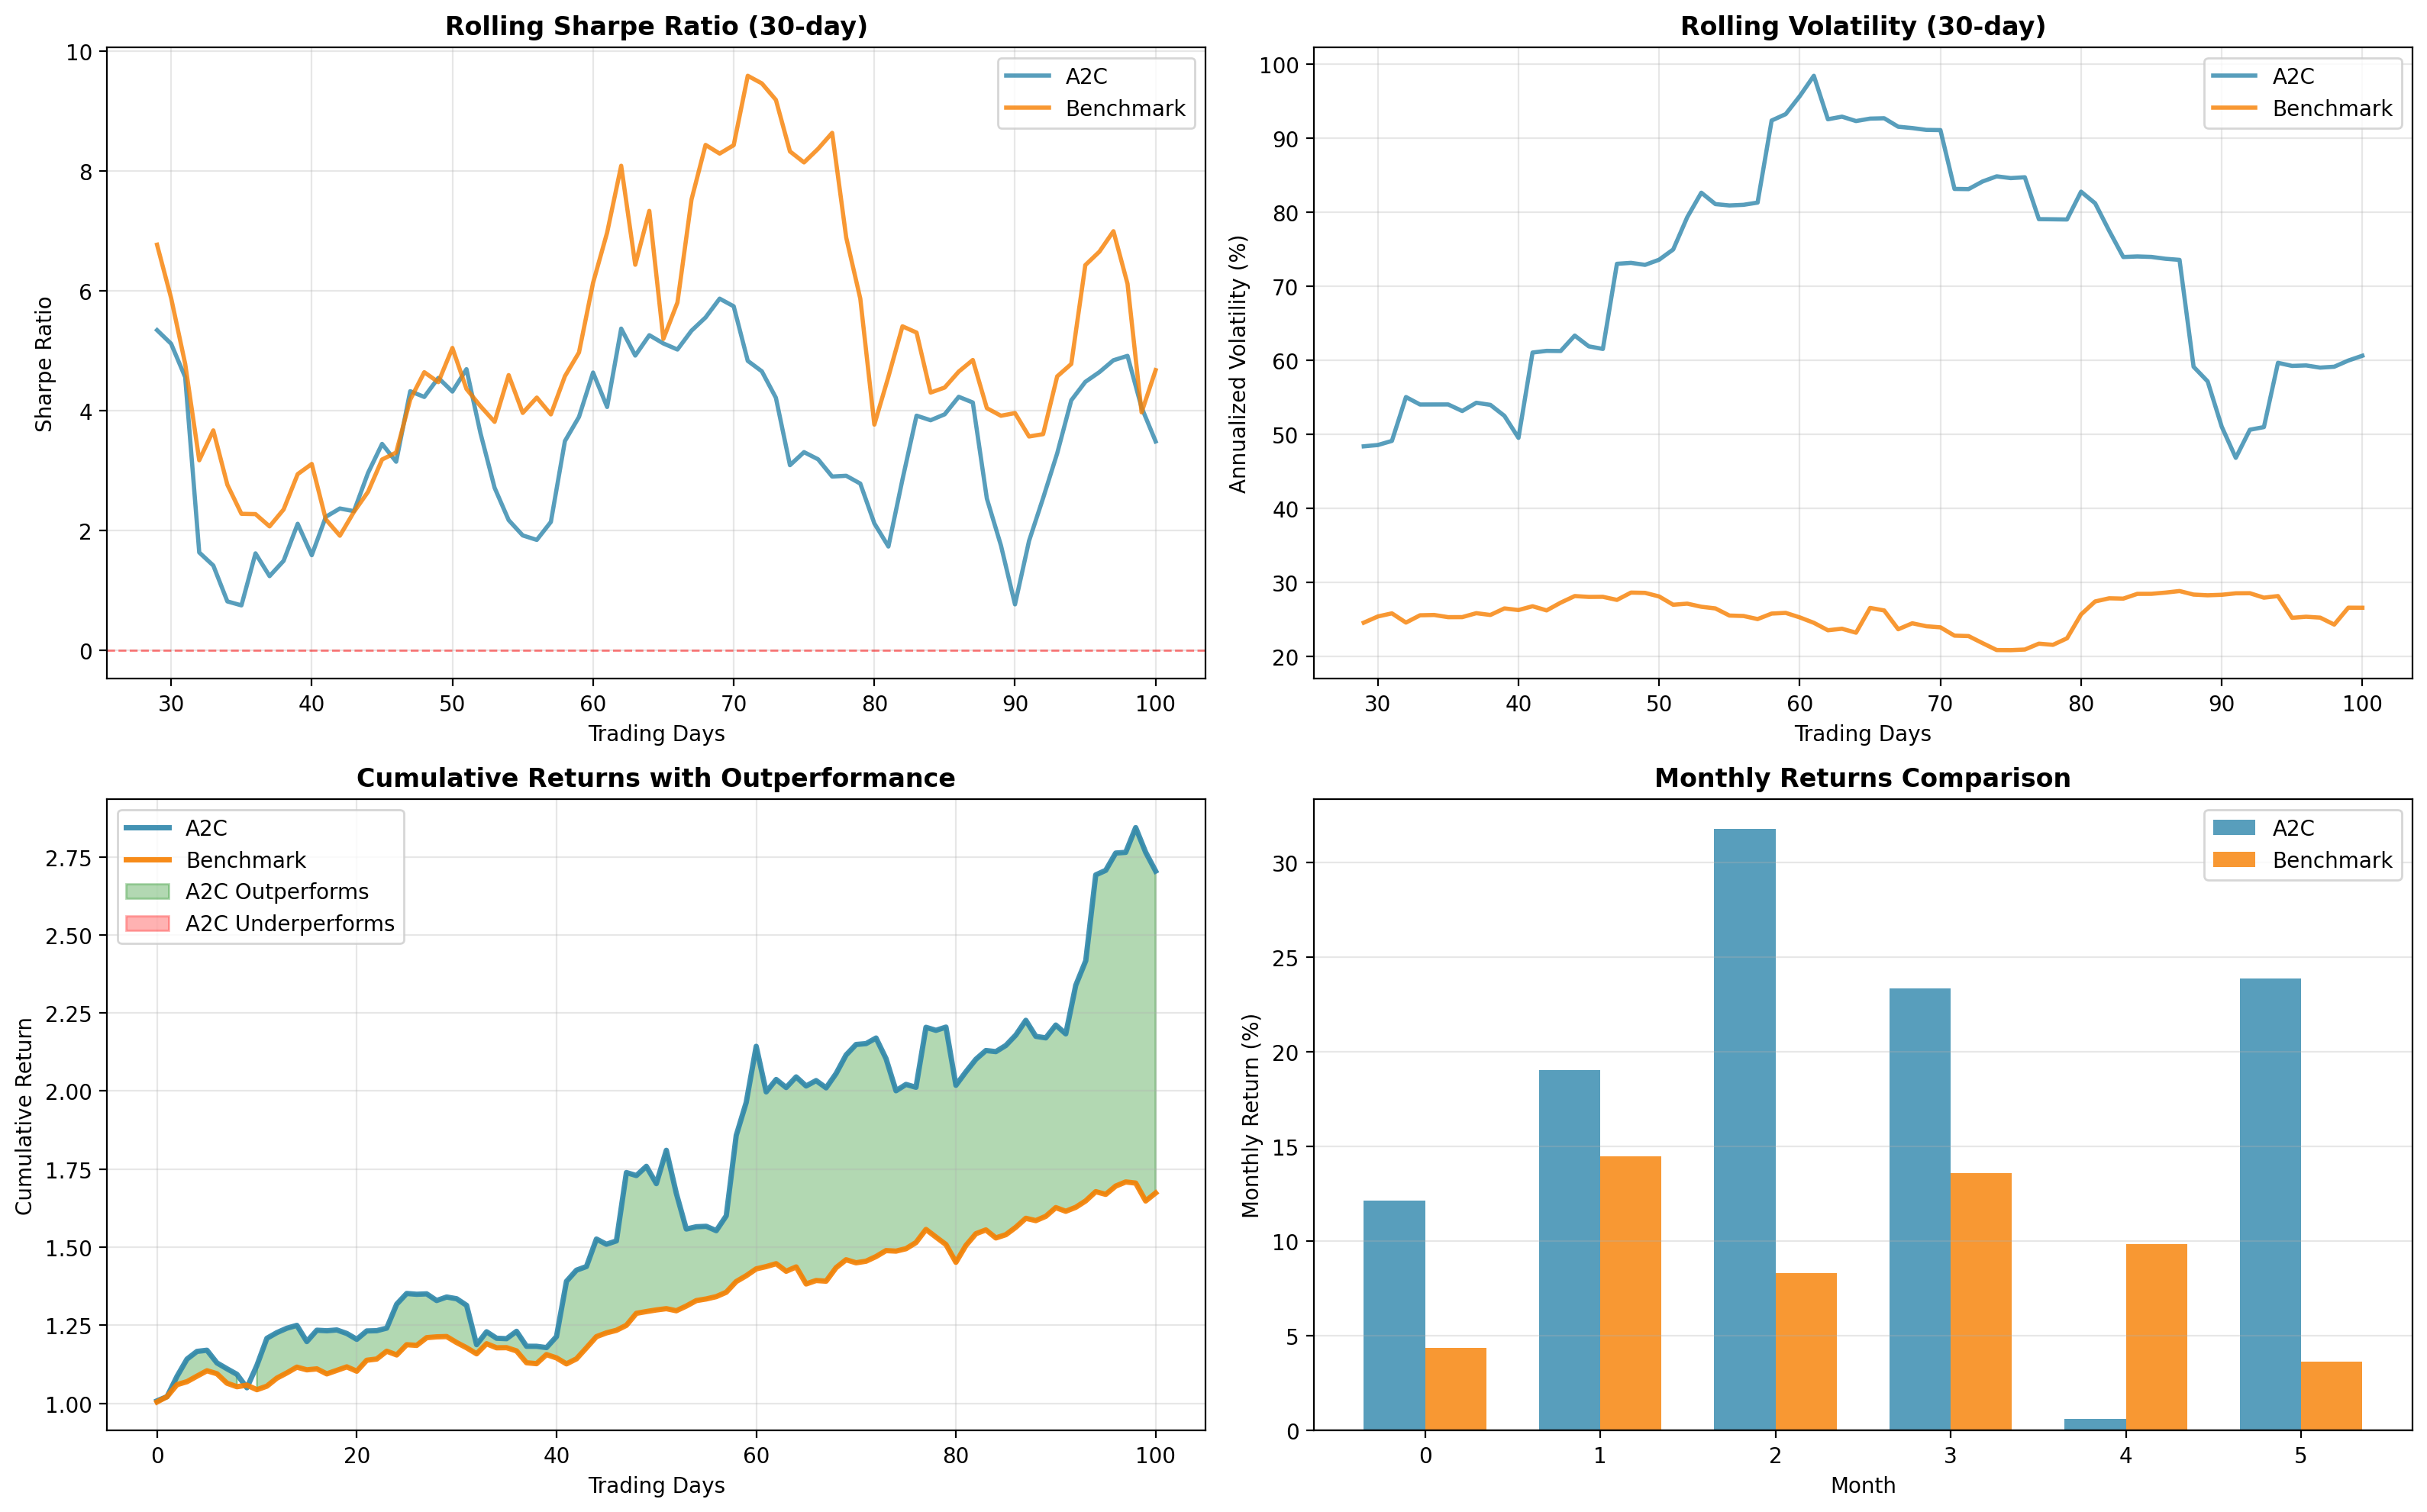

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Rolling Sharpe Ratio (30-day window)
window = 30
a2c_rolling_sharpe = pd.Series(a2c_rewards).rolling(window).mean() / pd.Series(a2c_rewards).rolling(window).std() * np.sqrt(252)
benchmark_rolling_sharpe = pd.Series(benchmark_rewards).rolling(window).mean() / pd.Series(benchmark_rewards).rolling(window).std() * np.sqrt(252)

ax1 = axes[0, 0]
ax1.plot(a2c_rolling_sharpe, label='A2C', linewidth=2, color='#2E86AB', alpha=0.8)
ax1.plot(benchmark_rolling_sharpe, label='Benchmark', linewidth=2, color='#F77F00', alpha=0.8)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_title(f'Rolling Sharpe Ratio ({window}-day)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Sharpe Ratio')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling Volatility
a2c_rolling_vol = pd.Series(a2c_rewards).rolling(window).std() * np.sqrt(252) * 100
benchmark_rolling_vol = pd.Series(benchmark_rewards).rolling(window).std() * np.sqrt(252) * 100

ax2 = axes[0, 1]
ax2.plot(a2c_rolling_vol, label='A2C', linewidth=2, color='#2E86AB', alpha=0.8)
ax2.plot(benchmark_rolling_vol, label='Benchmark', linewidth=2, color='#F77F00', alpha=0.8)
ax2.set_title(f'Rolling Volatility ({window}-day)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Annualized Volatility (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cumulative Returns (zoomed comparison)
ax3 = axes[1, 0]
ax3.plot(a2c_cumulative, label='A2C', linewidth=2.5, color='#2E86AB', alpha=0.9)
ax3.plot(benchmark_cumulative, label='Benchmark', linewidth=2.5, color='#F77F00', alpha=0.9)
ax3.fill_between(range(len(a2c_cumulative)), a2c_cumulative, benchmark_cumulative,
                  where=(a2c_cumulative >= benchmark_cumulative), alpha=0.3, color='green', label='A2C Outperforms')
ax3.fill_between(range(len(a2c_cumulative)), a2c_cumulative, benchmark_cumulative,
                  where=(a2c_cumulative < benchmark_cumulative), alpha=0.3, color='red', label='A2C Underperforms')
ax3.set_title('Cumulative Returns with Outperformance', fontsize=12, fontweight='bold')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Cumulative Return')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Monthly Returns Heatmap (Placeholder - requires date index manipulation)
ax4 = axes[1, 1]
monthly_a2c = pd.Series(a2c_rewards, index=df_test.index[:len(a2c_rewards)]).resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
monthly_benchmark = pd.Series(benchmark_rewards, index=df_test.index[:len(benchmark_rewards)]).resample('M').apply(lambda x: (1 + x).prod() - 1) * 100

x = range(len(monthly_a2c))
width = 0.35
ax4.bar([i - width/2 for i in x], monthly_a2c, width, label='A2C', color='#2E86AB', alpha=0.8)
ax4.bar([i + width/2 for i in x], monthly_benchmark, width, label='Benchmark', color='#F77F00', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax4.set_title('Monthly Returns Comparison', fontsize=12, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Monthly Return (%)')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [53]:
print("RISK ANALYSIS")
print("="*50)

# Value at Risk (VaR) - 95% confidence
a2c_var_95 = np.percentile(a2c_rewards, 5) * 100
benchmark_var_95 = np.percentile(benchmark_rewards, 5) * 100

print(f"Value at Risk (95% confidence):")
print(f"  A2C:       {a2c_var_95:.3f}% (worst daily loss expected 5% of the time)")
print(f"  Benchmark: {benchmark_var_95:.3f}%")

# Conditional VaR (CVaR) - Expected Shortfall
a2c_cvar_95 = np.mean(a2c_rewards[a2c_rewards <= np.percentile(a2c_rewards, 5)]) * 100
benchmark_cvar_95 = np.mean(benchmark_rewards[benchmark_rewards <= np.percentile(benchmark_rewards, 5)]) * 100

print(f"\nConditional VaR / Expected Shortfall (95%):")
print(f"  A2C:       {a2c_cvar_95:.3f}% (average of worst 5% days)")
print(f"  Benchmark: {benchmark_cvar_95:.3f}%")

# Downside deviation
a2c_downside_dev = np.std(a2c_rewards[a2c_rewards < 0]) * np.sqrt(252) * 100
benchmark_downside_dev = np.std(benchmark_rewards[benchmark_rewards < 0]) * np.sqrt(252) * 100

print(f"\nDownside Deviation (annualized):")
print(f"  A2C:       {a2c_downside_dev:.2f}%")
print(f"  Benchmark: {benchmark_downside_dev:.2f}%")

# Win rate
a2c_win_rate = np.sum(a2c_rewards > 0) / len(a2c_rewards) * 100
benchmark_win_rate = np.sum(benchmark_rewards > 0) / len(benchmark_rewards) * 100

print(f"\nWin Rate (% of positive days):")
print(f"  A2C:       {a2c_win_rate:.2f}%")
print(f"  Benchmark: {benchmark_win_rate:.2f}%")

# Best and worst days
print(f"\nBest Single Day:")
print(f"  A2C:       {np.max(a2c_rewards)*100:.3f}%")
print(f"  Benchmark: {np.max(benchmark_rewards)*100:.3f}%")

print(f"\nWorst Single Day:")
print(f"  A2C:       {np.min(a2c_rewards)*100:.3f}%")
print(f"  Benchmark: {np.min(benchmark_rewards)*100:.3f}%")

RISK ANALYSIS
Value at Risk (95% confidence):
  A2C:       -4.894% (worst daily loss expected 5% of the time)
  Benchmark: -1.680%

Conditional VaR / Expected Shortfall (95%):
  A2C:       -7.366% (average of worst 5% days)
  Benchmark: -3.104%

Downside Deviation (annualized):
  A2C:       39.03%
  Benchmark: 15.90%

Win Rate (% of positive days):
  A2C:       61.39%
  Benchmark: 67.33%

Best Single Day:
  A2C:       16.088%
  Benchmark: 3.775%

Worst Single Day:
  A2C:       -9.582%
  Benchmark: -3.801%
